# <font color='Brown'> Telecom Churn Case Study

### <font color='Green'> Problem Statement

<div style="text-align: justify">In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition. Hence, it is vital for us to understand which customers may churn so that the rentention strategies can be devised accordingly.<br></div>


### <font color='Green'> Business Objective

<div style="text-align: justify">In this project, our business objective is to analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn. Thus, our focus would be on<br></div>
(i) Retaining high profitable customers.<br>
(ii) Predicting which customers are at high risk of churn (in order to devise customer retention strategies accordingly).

In [272]:
#Required Imports are done below:
import pandas as pd, numpy as np
import re
import os

import missingno as msno # Library for visualizing missing data

from sklearn.impute import SimpleImputer # For handling missing values
from sklearn.preprocessing import StandardScaler # For feature scaling
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV # For data splitting and hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier # Random Forest classifier
from sklearn.decomposition import PCA # Principal Component Analysis for dimensionality reduction
from sklearn.manifold import TSNE # t-distributed Stochastic Neighbor Embedding for visualization
from sklearn.linear_model import LogisticRegression # Logistic Regression classifier
from sklearn.pipeline import Pipeline # For building machine learning pipelines
from sklearn.metrics import confusion_matrix, precision_score, recall_score # For model evaluation
from imblearn.over_sampling import SMOTE # For handling class imbalance
from sklearn.feature_selection import RFE # Recursive Feature Elimination
from xgboost import XGBClassifier # XGBoost classifier

import matplotlib.pyplot as plt # For plotting
from mpl_toolkits.mplot3d import Axes3D # For 3D plots
import seaborn as sns # For statistical data visualization
import warnings
warnings.filterwarnings("ignore") # Ignore warnings

%matplotlib inline 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None) #For print a long-sequence. Setting to None displays all items in a sequence.
pd.set_option('display.max_colwidth', 500) # Sets the maximum width of columns when displaying dataframes.
plotColor = ['b','g','r','m','c', 'y'] # List of colors for plotting

In [273]:
#Defining a function for coloring NaN and Non-NaN values
def color_style(value):
    """
    Takes a scalar (representing a percentage or count of NaNs) and returns a string with
    the css property `'color: red'` for value greater than 0 (indicating the presence of NaNs),
    green for value equal to 0 (indicating no NaNs), and black for any other cases (which shouldn't occur in this context).

    This function is intended to be used with Pandas' `style.applymap` to visually highlight cells
    representing NaN counts or percentages in a DataFrame.
    """
    if value > 0:
        color = 'red'  # Color red if NaNs are present
    elif value == 0:
        color = 'green' # Color green if no NaNs are present
    else:
        color = 'black' # Default color (shouldn't be used in typical NaN highlighting)
    return 'color: %s' % color

In [274]:
#Defining a function for missing value percentage dataframe: null_prcnt_df
def null_prcnt_df(data):
    """
    Calculates the percentage of missing values for each column in a DataFrame and returns a styled DataFrame
    highlighting columns with missing values.

    Args:
        data: The input Pandas DataFrame.

    Returns:
        A styled Pandas DataFrame showing the percentage of missing values for each column,
        with cells colored red if missing values are present (percentage > 0) and green if no
        missing values are present (percentage == 0).
    """
    df = data.copy() # Create a copy of the input DataFrame to avoid modifying the original
    missing = pd.DataFrame(100 * df.isnull().sum() / len(df.index)) # Calculate the percentage of missing values for each column
    missing.rename(columns={0: 'Null_Percentage'}, inplace=True) # Rename the column to 'Null_Percentage'
    missing = pd.DataFrame(missing.Null_Percentage).sort_values(by='Null_Percentage', ascending=False).style.applymap(color_style) # Sort by percentage and apply styling
    return missing

In [275]:
#Define a function for other evaluation metrics:
def other_metrics_logistic_model(confusion):
    """Calculates various evaluation metrics given a confusion matrix.""" # Docstring added
    TP = confusion[1,1] # true positive
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    sensitivity= round((TP) / (TP+FN),4) #sensitivity of our logistic regression model
    specificity= round((TN) / (TN+FP),4) #specificity  of our logistic regression model
    FPR= round((FP) / (TN+FP),4)        #False Positive Rate - predicting churn when customer does not have churned
    positive_pred_val= round((TP) / (TP+FP),4)  #Positive predictive value
    negative_pred_val= round((TN) / (TN+ FN),4) #Negative predictive value
    misclass_rate = round((FN+FP)/(TP+TN+FP+FN),4)  #Misclassification rate
    accuracy = round((TN+TP)/(TP+TN+FP+FN),4)

    metric_list= ['Accuracy', 'Sensitivity/Recall', 'Specificity', 'False Positive Rate','Positive Predictive Value/Precision','Negative Predictive Value', 'Misclassification Rate']
    metric_val = [accuracy, sensitivity, specificity, FPR, positive_pred_val, negative_pred_val, misclass_rate]
    evaluation_metrics_df=pd.DataFrame({'Evaluation Metrics':metric_list, 'Value': metric_val})
    evaluation_metrics_df.set_index("Evaluation Metrics", inplace= True)
    return evaluation_metrics_df

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [277]:
data = pd.read_csv("train.csv") 
unseen = pd.read_csv("test.csv") 
data_dict = pd.read_csv("data_dictionary.csv") 

print(data.shape)
print(unseen.shape) 
print(data_dict.shape) 

(69999, 172)
(30000, 171)
(36, 2)


In [278]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belongs to
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile to mobile
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [279]:
data.head(5)

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [280]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

# 2. Handling Missing data and Exploratory Data Analysis & Preprocessing
   
First lets analyse the missing dat and then start the process of EDA and preprocessing..

In [282]:
data = data.drop_duplicates()  # Removes duplicate rows from the 'data' DataFrame, keeping only the first occurrence of each unique row.
unseen = unseen.drop_duplicates() # Removes duplicate rows from the 'unseen' DataFrame, keeping only the first occurrence of each unique row.

In [283]:
# Removing columns that show constant variance (i.e. all values are constant or 0)
def remove_SingleUniqueValue_column(df):
    """
    Removes columns from a DataFrame that have only a single unique value (constant columns).

    Args:
        df: The input Pandas DataFrame.

    Returns:
        A new Pandas DataFrame with the constant columns removed.
    """
    df_newsingle = df.copy()  # Create a copy of the DataFrame to avoid modifying the original.
    uniq_svcol = df_newsingle.nunique() == 1  # Identify columns with only one unique value. Returns a boolean Series.
    list_uniq_svcol = list(uniq_svcol[uniq_svcol.values == True].index)  # Create a list of column names that have only one unique value.
    df_newsingle.drop(list_uniq_svcol, axis=1, inplace=True)  # Drop the identified columns from the DataFrame.
    print('Columns that are dropped are:\n{0}'.format(list_uniq_svcol))  # Print the names of the dropped columns.
    print('\nNumber of columns dropped:\n{0}'.format(len(list_uniq_svcol)))  # Print the number of dropped columns.
    return df_newsingle  # Return the modified DataFrame.

print("For Training Data:")
data = remove_SingleUniqueValue_column(data)  # Remove constant columns from the 'data' DataFrame.
print("============================================================================================")
print("For Test Data:")
unseen = remove_SingleUniqueValue_column(unseen)  # Remove constant columns from the 'unseen' DataFrame.

For Training Data:
Columns that are dropped are:
['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

Number of columns dropped:
13
For Test Data:
Columns that are dropped are:
['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

Number of columns dropped:
13


In [284]:
#Unique count dataframe
def hv_categorical_cols_unique(data):
    """
    Identifies and summarizes potential categorical columns in a DataFrame based on the number of unique values.

    Args:
        data: The input Pandas DataFrame.

    Returns:
        A Pandas DataFrame summarizing potential categorical columns, their data types, unique value counts, and unique values.
        Returns an empty DataFrame if no suitable columns are found.
    """
    df = data.copy()  # Create a copy of the DataFrame to avoid modifying the original.
    unique_count = []  # Initialize an empty list to store unique counts (not used after refactoring)
    unique_val = []  # Initialize an empty list to store unique values (not used after refactoring)
    col_list = []  # Initialize an empty list to store column names (not used after refactoring)
    data_type = []  # Initialize an empty list to store data types (not used after refactoring)
    unique_data = [] # Initialize an empty list to store dictionaries of feature information

    for col in df.columns:
        if len(df[col].unique()) < 20:  # Set a threshold to check for the distinct values of potential categorical datatype columns
            unique_data.append({ # Append a dictionary with feature info
                'Features': col, # Store the feature name
                'Data Type': df[col].dtype, # Store the feature data type
                'Unique Count': len(df[col].unique()), # Store the number of unique values
                'Unique Values': df[col].unique().tolist()  # Store unique values as a list
            })
    if not unique_data: #Check if the list is empty
        return pd.DataFrame() #Return empty dataframe if no suitable columns are found
    unique_df = pd.DataFrame(unique_data) # Create DataFrame from the list of dictionaries
    unique_df.set_index('Features', inplace=True) # Set feature name as index
    sorted_df = unique_df.sort_values(by='Unique Count', ascending=True) # Sort by unique count
    return sorted_df # Return the sorted DataFrame

print("============================================================================================")
print("Checking for potential categorical datatype columns:")
hv_categorical_cols_unique(data=data) # Call the function and print the result

Checking for potential categorical datatype columns:


,Data Type,Unique Count,Unique Values
Features,,,
churn_probability,int64,2,"[0, 1]"
night_pck_user_6,float64,3,"[nan, 0.0, 1.0]"
night_pck_user_7,float64,3,"[nan, 0.0, 1.0]"
night_pck_user_8,float64,3,"[nan, 0.0, 1.0]"
fb_user_6,float64,3,"[nan, 1.0, 0.0]"
fb_user_7,float64,3,"[nan, 1.0, 0.0]"
fb_user_8,float64,3,"[nan, 1.0, 0.0]"
monthly_2g_6,int64,5,"[0, 1, 2, 3, 4]"
monthly_2g_7,int64,6,"[0, 1, 2, 4, 3, 5]"


In [285]:
rech_cols = [i for i in data.columns if re.search("rech_amt|rech_data",i)]
rech_cols

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8']

In [286]:
# Checking for null values in the columns related to recharge:
recharge_df = pd.DataFrame(data[rech_cols])  
# Creates a new DataFrame 'recharge_df' containing only the columns from 'data' that are present 
# in the 'rech_cols' list (recharge-related columns).
null_prcnt_df(recharge_df)  
# Calls the 'null_prcnt_df' function (defined earlier) on the 'recharge_df' to calculate and 
#display the percentage of null values in each recharge-related column.

,Null_Percentage
total_rech_data_6,74.902499
av_rech_amt_data_6,74.902499
date_of_last_rech_data_6,74.902499
max_rech_data_6,74.902499
total_rech_data_7,74.478207
av_rech_amt_data_7,74.478207
max_rech_data_7,74.478207
date_of_last_rech_data_7,74.478207
max_rech_data_8,73.689624
total_rech_data_8,73.689624


In [287]:
recharge_df.describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000
mean,328.139788,322.376363,323.846355,104.569265,104.137573,107.540351,2.467612,2.679989,2.652441,126.500000,126.402071,125.374925,192.831096,201.455940,196.815792
std,404.211068,411.070120,426.181405,121.407701,120.782543,124.396750,2.794610,3.073472,3.101265,109.352573,109.459266,109.648799,190.623115,198.346141,192.280532
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,110.000000,100.000000,90.000000,30.000000,30.000000,30.000000,1.000000,1.000000,1.000000,25.000000,25.000000,25.000000,82.000000,92.000000,84.000000
50%,229.000000,220.000000,225.000000,110.000000,110.000000,98.000000,1.000000,2.000000,1.000000,145.000000,145.000000,145.000000,154.000000,154.000000,154.000000
75%,438.000000,430.000000,436.000000,120.000000,128.000000,144.000000,3.000000,3.000000,3.000000,177.000000,177.000000,179.000000,252.000000,252.000000,252.000000
max,35190.000000,40335.000000,45320.000000,4010.000000,3299.000000,4449.000000,61.000000,54.000000,60.000000,1555.000000,1555.000000,1555.000000,5920.000000,4365.000000,4076.000000


In [288]:
# Columns having minimum value as 1, can be imputed to 0, indicating no recharge was done.
rech_cols_min = ["total_rech_data_6", "total_rech_data_7", "total_rech_data_8",
                 "max_rech_data_6", "max_rech_data_7", "max_rech_data_8",
                 "av_rech_amt_data_6", "av_rech_amt_data_7", "av_rech_amt_data_8"] # List of recharge-related columns to be imputed.

imp = SimpleImputer(strategy='constant', fill_value=0) # Creates a SimpleImputer object with a 'constant' strategy and a fill value of 0. This will replace missing values with 0.
data[rech_cols_min] = imp.fit_transform(data[rech_cols_min]) # Fits the imputer on the specified columns of the 'data' DataFrame and then transforms (imputes) those columns in place.
unseen[rech_cols_min] = imp.fit_transform(unseen[rech_cols_min]) # Fits the imputer on the

In [289]:
data["tot_rech_data_amt_6"] = data["av_rech_amt_data_6"] * data["total_rech_data_6"]
data["tot_rech_data_amt_7"] = data["av_rech_amt_data_7"] * data["total_rech_data_7"]
data["tot_rech_data_amt_8"] = data["av_rech_amt_data_8"] * data["total_rech_data_8"]

# average recharge data amount for 6th and 7th month (good phase)
data["av_rech_data_amt_6_7"] = ((data["tot_rech_data_amt_6"] + data["total_rech_amt_6"])
                                + (data["tot_rech_data_amt_7"]+ data["total_rech_amt_7"]))/2


In [290]:
def plot_boxplots_6_7_8(feature):  # Defines a function to plot boxplots for a given feature across months 6, 7, and 8
    plt.figure(figsize=(24, 10))  # Creates a figure with a specified size and DPI for higher resolution
    df = data.copy()  # Creates a copy of the 'data' DataFrame to avoid modifying the original

    # Color palette
    colors = {"Not Churned": "#32CD32", "Churned": "#FF4500"}  # Defines a dictionary to map churn labels to colors

    for i, month in enumerate([6, 7, 8]):  # Iterates through months 6, 7, and 8 using enumerate to get both index and value
        plt.subplot(1, 3, i + 1)  # Creates a subplot in a 1x3 grid (1 row, 3 columns)

        ax = sns.boxplot(  # Creates a boxplot using Seaborn
            data=df,  # Uses the copied DataFrame
            y=feature + f"_{month}",  # Sets the y-axis variable (feature name + month)
            x="churn_probability",  # Sets the x-axis variable ("churn_probability")
            showfliers=False,  # Hides outlier points (fliers) for cleaner visualization
            palette=[colors["Not Churned"], colors["Churned"]],  # Sets the color palette for the boxes
            width=0.5  # Sets the width of the boxes
        )

        plt.title(f"\nBoxplot: '{feature}_{month}'\n", fontsize=22, fontweight='bold')  # Sets the title of the subplot
        plt.ylabel(feature + f"_{month}", fontsize=20, fontstyle='italic')  # Sets the y-axis label
        plt.xlabel("Churn", fontsize=22, fontstyle='italic')  # Sets the x-axis label
        plt.xticks([0, 1], ['Not Churned\n(Retention)', 'Churned'], fontsize=18)  # Sets x-axis tick labels and font size
        plt.yticks(fontsize=16)  # Sets y-axis tick font size

        # Create custom legend elements
        from matplotlib.patches import Patch  # Imports the Patch class for creating legend elements
        legend_elements = [  # Creates a list of Patch objects for the legend
            Patch(facecolor=colors["Not Churned"], label='Not Churned (Retention)'),  # Creates a patch for "Not Churned"
            Patch(facecolor=colors["Churned"], label='Churned'),  # Creates a patch for "Churned"
        ]
        ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 0.95), fontsize=12,  # Adds a legend to the subplot
                  frameon=True, framealpha=1, shadow=True, borderpad=1, facecolor='white')  # Customizes the legend appearance

    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjusts subplot parameters to provide padding
    plt.show()  # Displays the plot

In [291]:
def plot_barplots_6_7_8(feature):
    """Plots barplots for a given feature across months 6, 7, and 8, comparing churn probability."""
    # Set a larger figure size for better readability (optional)
    plt.figure(figsize=(18, 8))  # Creates a new figure with a specified size

    df = data.copy()  # Creates a copy of the 'data' DataFrame to avoid modifying the original

    colors = {"Not Churned": "#32CD32", "Churned": "#FF4500"}  # Defines a dictionary to map churn labels to colors

    # Create a grid of subplots and iterate through months
    for i, month in enumerate([6, 7, 8]):  # Iterates through months 6, 7, and 8
        ax = plt.subplot(1, 3, i + 1)  # Creates a subplot in a 1x3 grid (1 row, 3 columns)

        # Create barplot with customized labels and title
        sns.barplot(
            data=df,  # Uses the copied DataFrame
            y=feature + f"_{month}",  # Sets the y-axis variable (feature name + month)
            x="churn_probability",  # Sets the x-axis variable ("churn_probability")
            hue="churn_probability",  # Sets the hue (color) based on the churn probability
            palette=[colors["Not Churned"], colors["Churned"]],  # Sets the color palette for the bars
            width=0.5  # Sets the width of the bars
        )
        ax.set_xticklabels(["Not Churned\n(Retention)", "Churned"], fontsize=16)  # Sets x-axis tick labels and font size
        plt.title(f"\nBarplot: '{feature}_{month}'\n", fontsize=20, fontweight='bold')  # Sets the title of the subplot
        plt.ylabel(feature + f"_{month}", fontsize=16, fontstyle='italic')  # Sets the y-axis label
        plt.xlabel("Churn", fontsize=16, fontstyle='italic')  # Sets the x-axis label
        plt.xticks(fontsize=14)  # Sets x-axis tick font size
        plt.yticks(fontsize=14)  # Sets y-axis tick font size

        # Leverage vectorized legend element retrieval (assuming legends are generated)
        from matplotlib.patches import Patch  # Imports the Patch class for creating legend elements
        legend_elements = [  # Creates a list of Patch objects for the legend
            Patch(facecolor=colors["Not Churned"], label='Not Churned (Retention)'),  # Creates a patch for "Not Churned"
            Patch(facecolor=colors["Churned"], label='Churned'),  # Creates a patch for "Churned"
        ]
        ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 0.95), fontsize=12,  # Adds a legend to the subplot
                  frameon=True, framealpha=1, shadow=True, borderpad=1, facecolor='white')  # Customizes the legend appearance

    plt.tight_layout()  # Adjusts subplot parameters for a tight layout
    plt.show()  # Displays the plot

In [292]:
def plot_countplots_6_7_8(feature):
    """
    Creates countplots to visualize the distribution of a given feature across
    churn probability for months 6, 7, and 8.

    Args:
        feature (str): The name of the feature to visualize.
    """

    colors = {"Not Churned": "#32CD32", "Churned": "#FF4500"}  # Defines a color dictionary for churn labels
    plt.figure(figsize=(24, 10))  # Creates a large figure for better readability

    df = data.copy()  # Creates a copy of the 'data' DataFrame to avoid modifying the original

    for i, month in enumerate([6, 7, 8]):  # Iterates through months 6, 7, and 8
        plt.subplot(1, 3, i + 1)  # Creates a subplot in a 1x3 grid layout

        # Create countplot with customized labels and title
        ax = sns.countplot(
            data=df,  # Uses the copied DataFrame
            x=feature + f"_{month}",  # Sets the x-axis variable (feature name + month)
            hue="churn_probability",  # Sets the hue (color) based on churn probability
            palette=[colors["Not Churned"], colors["Churned"]],  # Sets the color palette for the bars
        )
        plt.title(f"\nCountplot: '{feature}_{month}'\n", fontsize=22, fontweight='bold')  # Sets the subplot title
        plt.ylabel(feature + f"_{month}", fontsize=16, fontstyle='italic')  # Sets the y-axis label
        plt.xlabel("Churn", fontsize=22, fontstyle='italic')  # Sets the x-axis label
        plt.xticks(fontsize=16, rotation=45)  # Sets x-axis tick labels, font size, and rotates for better readability
        plt.yticks(fontsize=16)  # Sets y-axis tick font size

        # Create custom legend elements
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=colors["Not Churned"], label='Not Churned (Retention)'),
            Patch(facecolor=colors["Churned"], label='Churned'),
        ]
        ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 0.95), fontsize=12,
                  frameon=True, framealpha=1, shadow=True, borderpad=1, facecolor='white')  # Adds a legend to the subplot

    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjusts subplot parameters to make space for the legend
    plt.show()  # Displays the plot

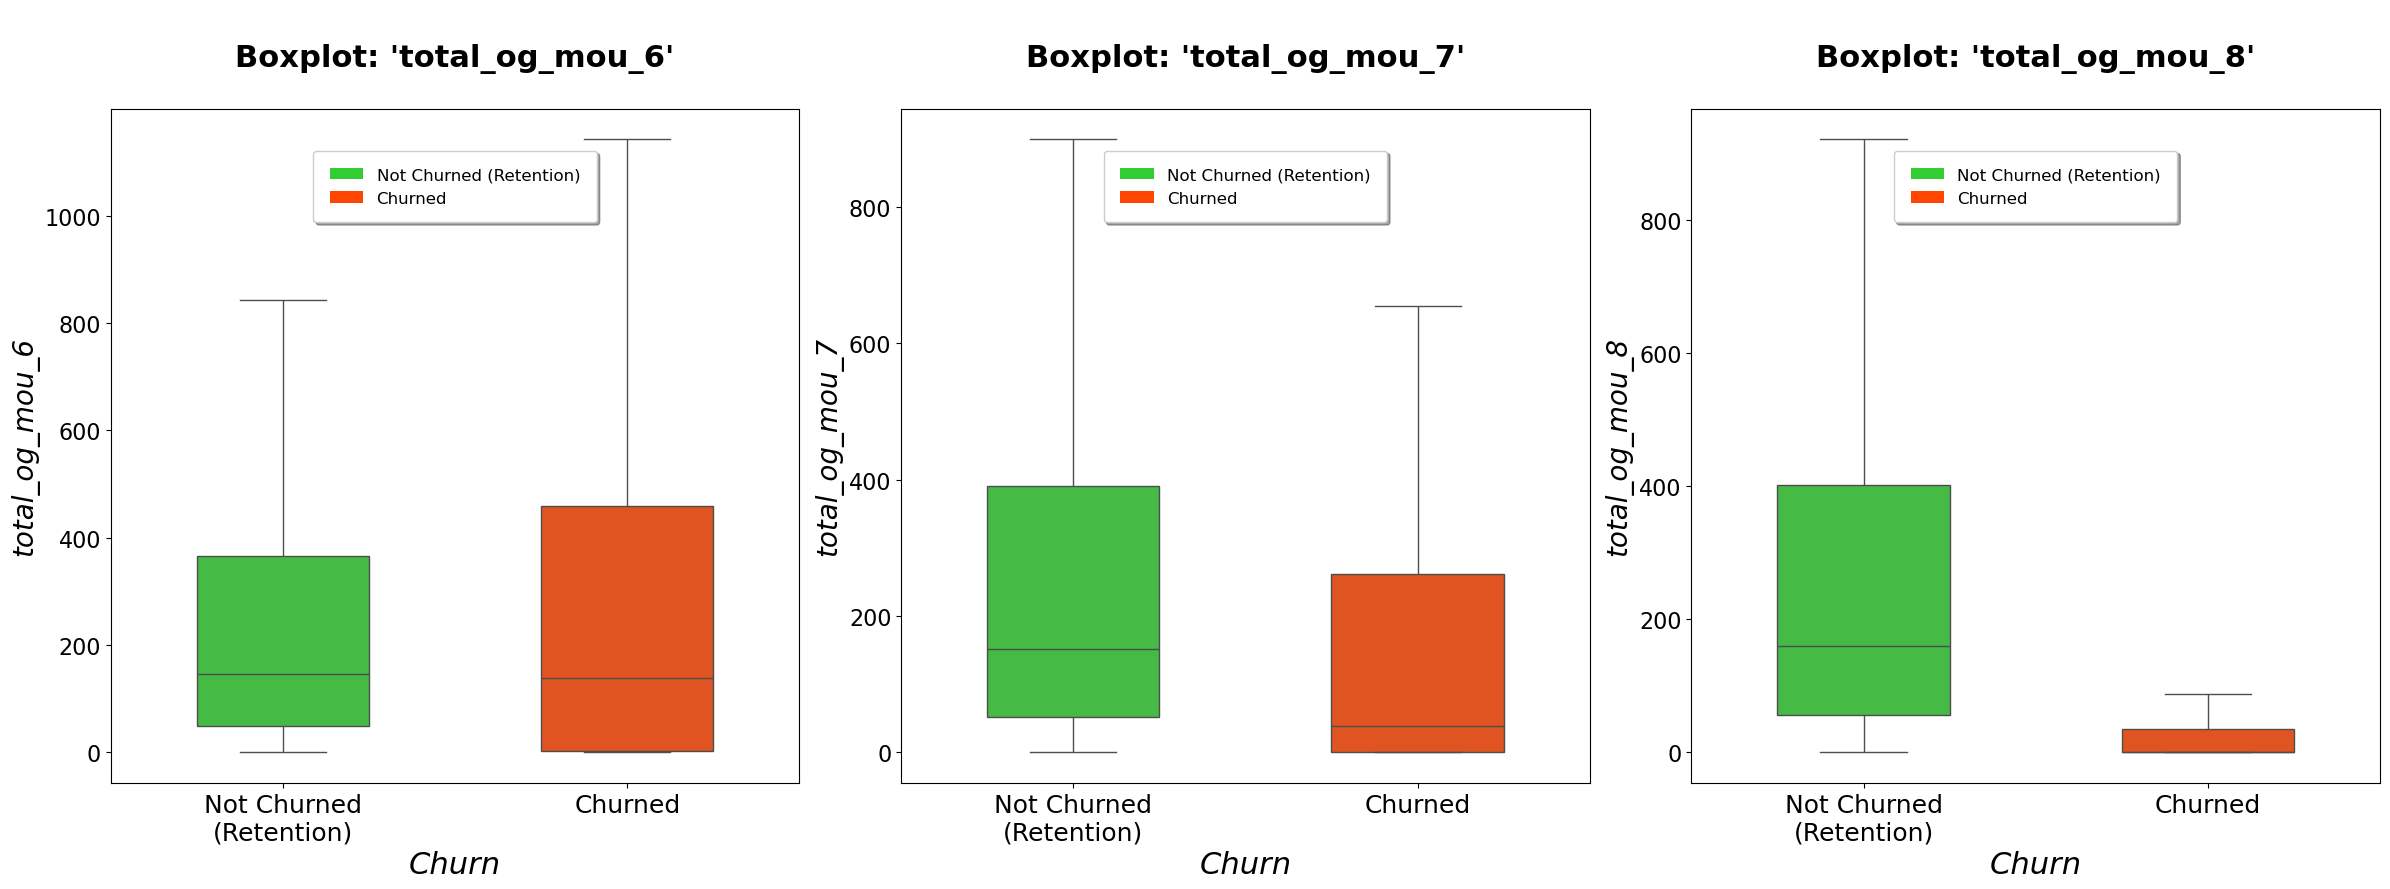

In [293]:
# Total Outgoing
plot_boxplots_6_7_8("total_og_mou")

#General Observations

Outliers: There are some outliers present in the data, especially for the churned customers in total_og_mou_6. These outliers suggest that some churned customers have significantly higher outgoing minutes compared to the majority.
Churn vs. Non-Churn

Median: The median outgoing minutes for churned customers are generally lower than those for non-churned customers across all three months. This suggests that customers who churn tend to have lower outgoing minutes.
Distribution: The distribution of outgoing minutes for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in total_og_mou_6. This indicates that churned customers exhibit a wider range of outgoing minutes.
Month-to-Month Comparison

Total_og_mou_6: The median outgoing minutes for both churned and non-churned customers are highest in this month.
Total_og_mou_7: There's a slight decrease in the median outgoing minutes for both groups compared to total_og_mou_6.
Total_og_mou_8: The median outgoing minutes continue to decrease for both groups compared to the previous months.
Possible Interpretations

Lower Usage as a Churn Indicator: The lower outgoing minutes for churned customers might suggest that decreasing usage is a potential indicator of churn.
Usage Patterns and Churn: The spread in outgoing minutes for churned customers might indicate that there are different usage patterns among customers who churn. Some might have very low usage, while others might have high usage but still churn due to other factors.

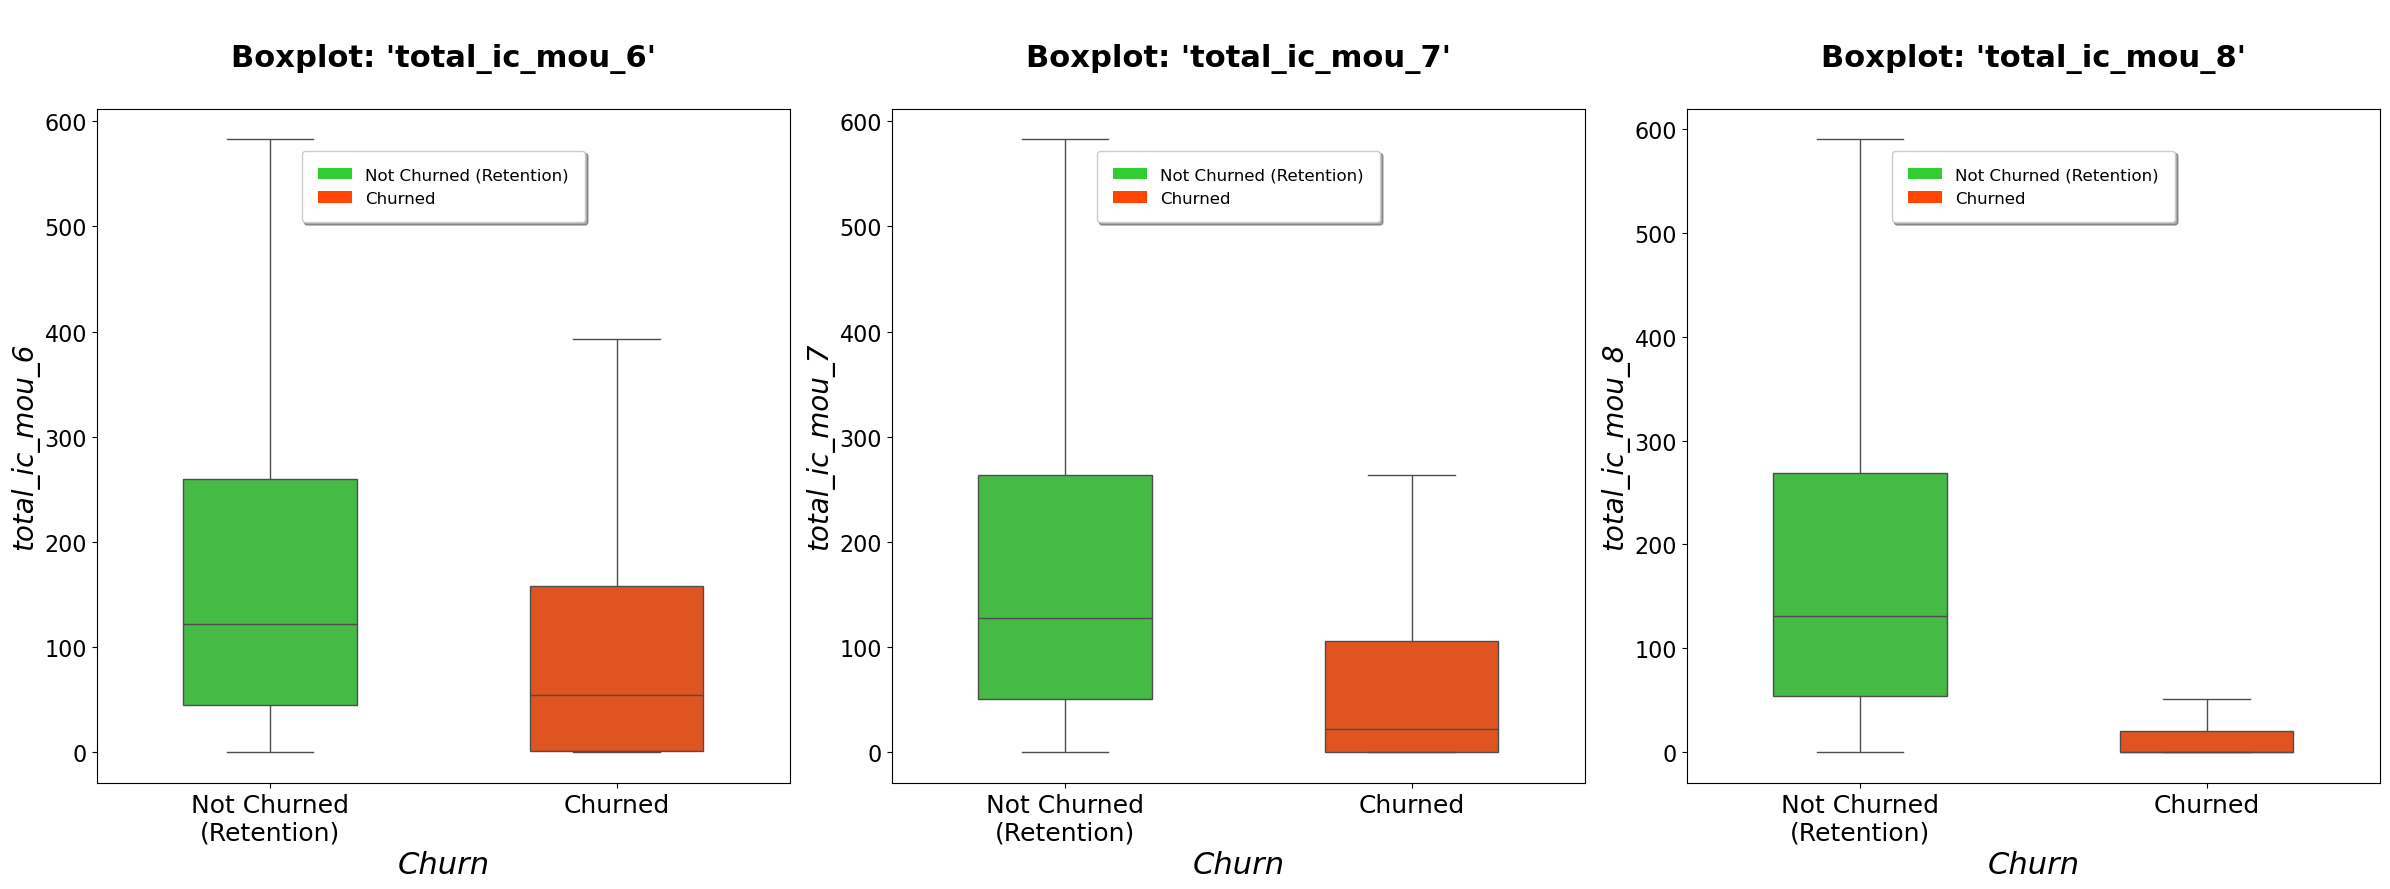

In [295]:
# Total Incoming
plot_boxplots_6_7_8("total_ic_mou")

#General Observations

Outliers: There are some outliers present in the data, especially for the churned customers in total_ic_mou_6. These outliers suggest that some churned customers have significantly higher incoming minutes compared to the majority.
Churn vs. Non-Churn

Median: The median incoming minutes for churned customers are generally lower than those for non-churned customers across all three months. This suggests that customers who churn tend to have lower incoming minutes.
Distribution: The distribution of incoming minutes for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in total_ic_mou_6. This indicates that churned customers exhibit a wider range of incoming minutes.
Month-to-Month Comparison

Total_ic_mou_6: The median incoming minutes for both churned and non-churned customers are highest in this month.
Total_ic_mou_7: There's a slight decrease in the median incoming minutes for both groups compared to total_ic_mou_6.
Total_ic_mou_8: The median incoming minutes continue to decrease for both groups compared to the previous months.
Possible Interpretations

Lower Usage as a Churn Indicator: The lower incoming minutes for churned customers might suggest that decreasing usage is a potential indicator of churn.
Usage Patterns and Churn: The spread in incoming minutes for churned customers might indicate that there are different usage patterns among customers who churn. Some might have very low usage, while others might have high usage but still churn due to other factors.



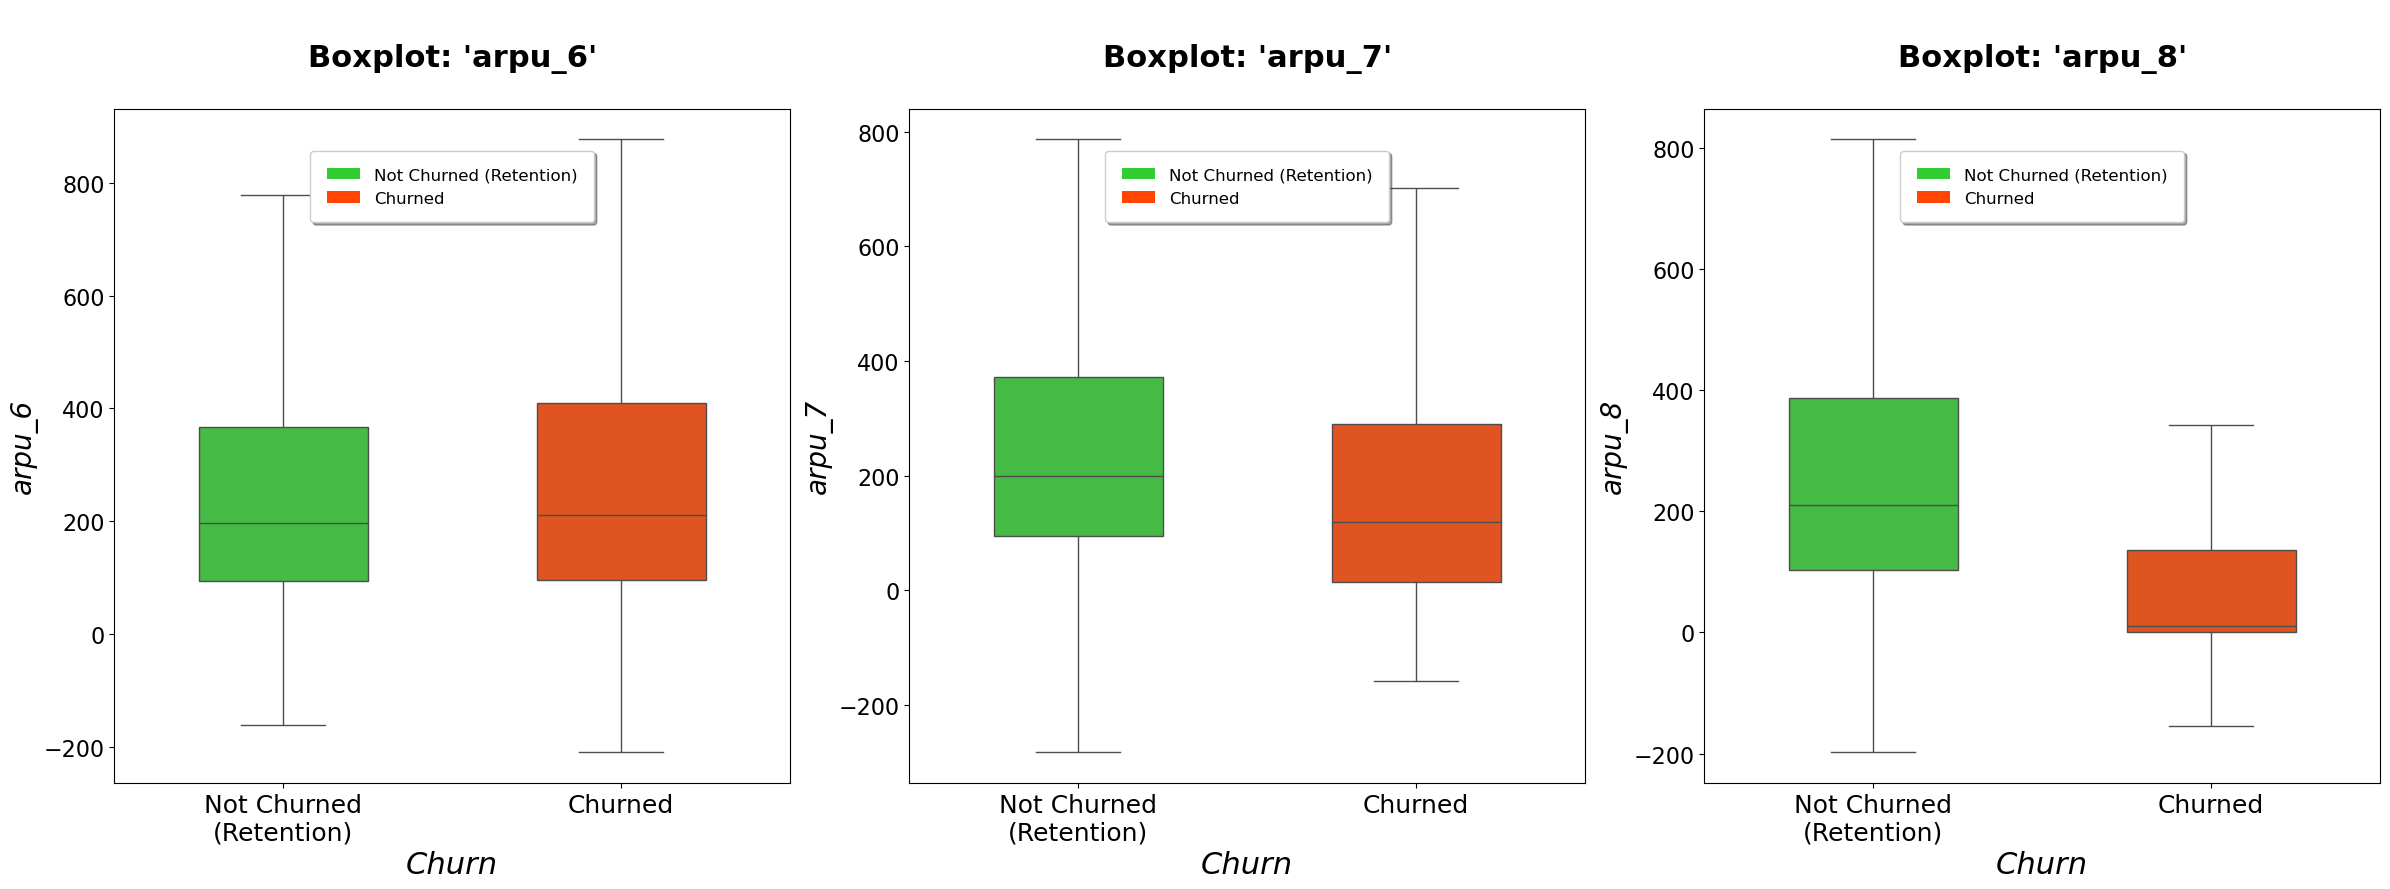

In [297]:
# Average Revenue Per User
plot_boxplots_6_7_8("arpu")

#General Observations:

Outliers: There are some outliers present in the data, especially for churned customers in arpu_6. This indicates that a few churned customers had significantly higher ARPU compared to the majority.
Churn vs. Non-Churn

Median: The median ARPU for churned customers is generally lower than that for non-churned customers across all three months. This suggests that customers who churn tend to have lower revenue generation.
Distribution: The distribution of ARPU for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in arpu_6. This indicates that churned customers exhibit a wider range of ARPU values.
Month-to-Month Comparison

arpu_6: The median ARPU for both churned and non-churned customers is highest in this month.
arpu_7: There's a slight decrease in the median ARPU for both groups compared to arpu_6.
arpu_8: The median ARPU continues to decrease for both groups compared to the previous months.
Possible Interpretations

Revenue Decline as Churn Indicator: The lower ARPU for churned customers might suggest that decreasing revenue generation is a potential indicator of churn.
Revenue Patterns and Churn: The spread in ARPU for churned customers might indicate that there are different revenue patterns among customers who churn. Some might have very low revenue, while others might have higher revenue but still churn due to other factors.



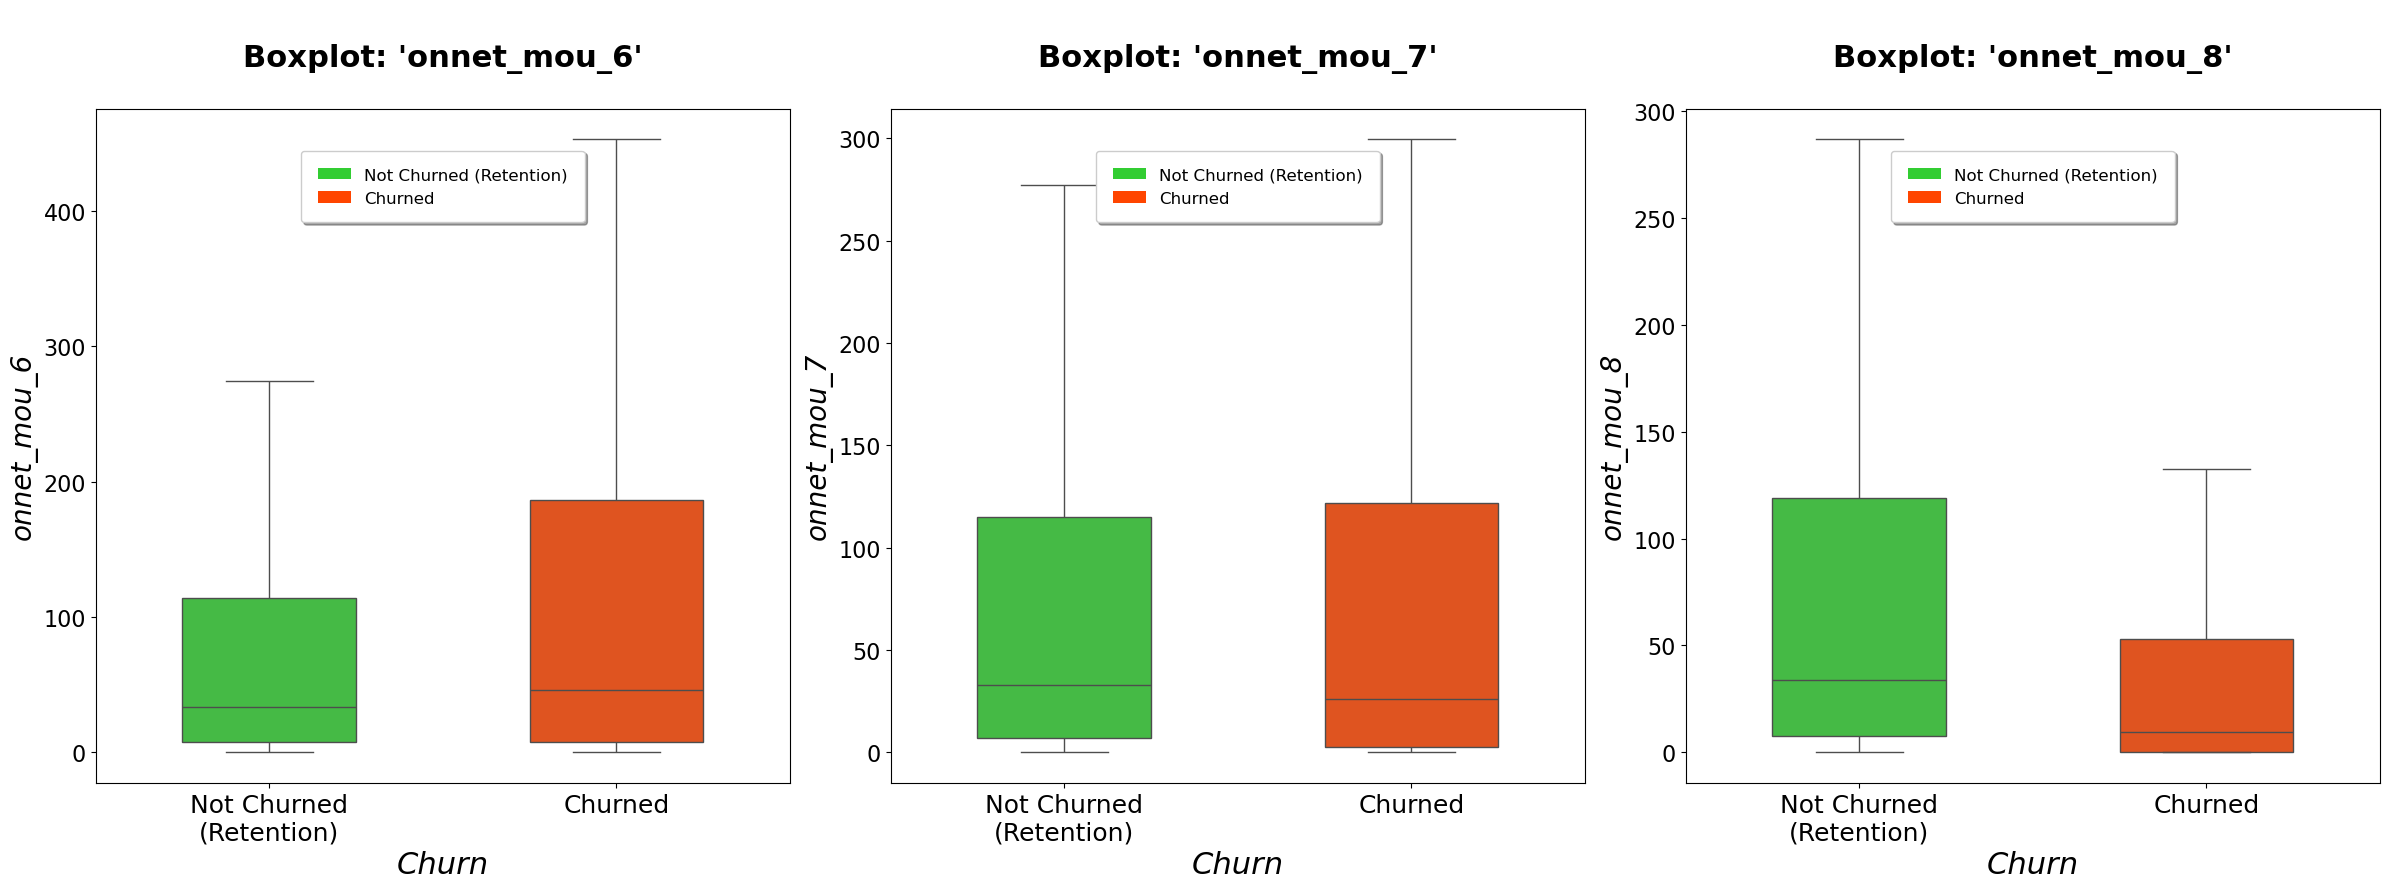

In [299]:
# Minutes of Usage on-network
plot_boxplots_6_7_8("onnet_mou")

##General Observations

Outliers: There are some outliers present in the data, especially for the churned customers in onnet_mou_6. These outliers suggest that some churned customers have significantly higher on-net minutes compared to the majority.
Churn vs. Non-Churn

Median: The median on-net minutes for churned customers are generally lower than those for non-churned customers across all three months. This suggests that customers who churn tend to have lower on-net minutes.
Distribution: The distribution of on-net minutes for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in onnet_mou_6. This indicates that churned customers exhibit a wider range of on-net minutes.
Month-to-Month Comparison

onnet_mou_6: The median on-net minutes for both churned and non-churned customers are highest in this month.
onnet_mou_7: There's a slight decrease in the median on-net minutes for both groups compared to onnet_mou_6.
onnet_mou_8: The median on-net minutes continue to decrease for both groups compared to the previous months.
Possible Interpretations

Lower Usage as a Churn Indicator: The lower on-net minutes for churned customers might suggest that decreasing usage is a potential indicator of churn.
Usage Patterns and Churn: The spread in on-net minutes for churned customers might indicate that there are different usage patterns among customers who churn. Some might have very low usage, while others might have high usage but still churn due to other factors.



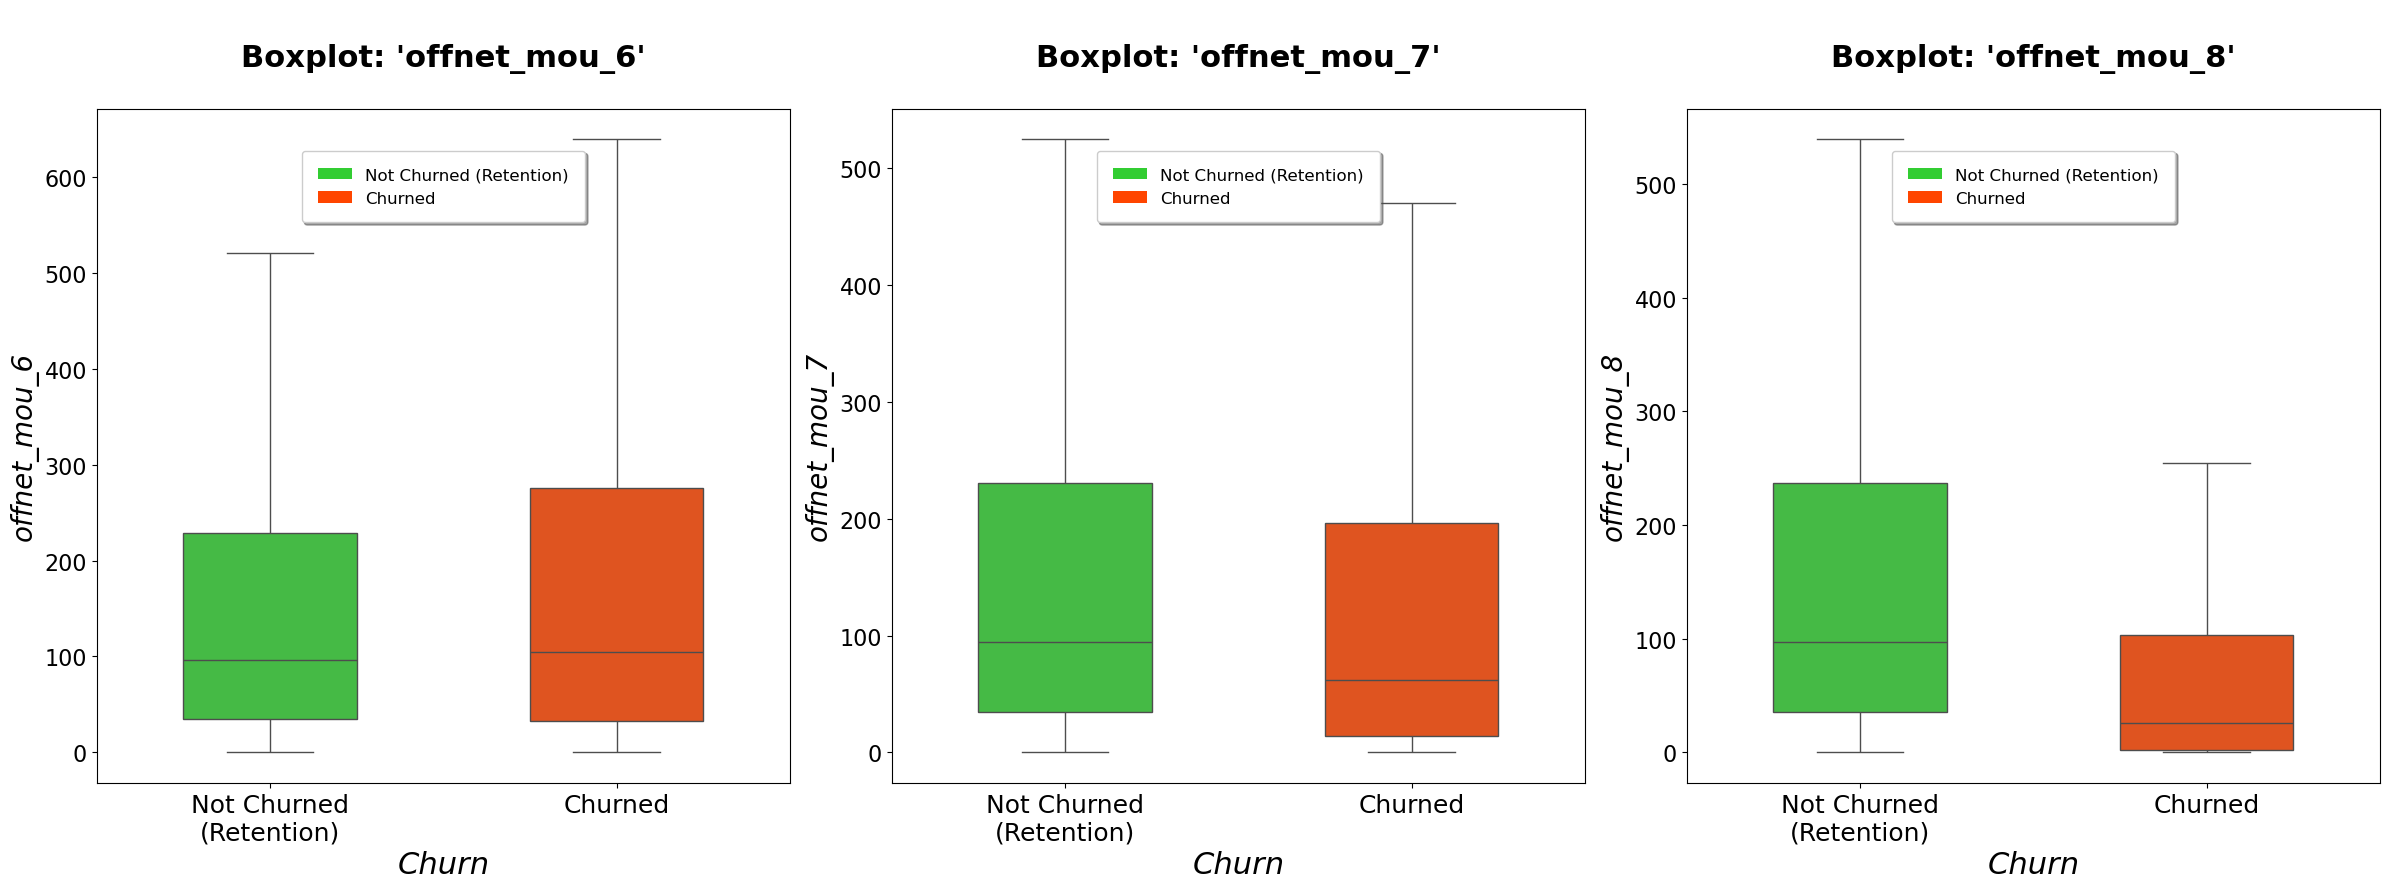

In [301]:
#Minutes of Usage off-network
plot_boxplots_6_7_8("offnet_mou")

##General Observations

Outliers: There are some outliers present in the data, especially for the churned customers in offnet_mou_6. These outliers suggest that some churned customers have significantly higher off-net minutes compared to the majority.
Churn vs. Non-Churn

Median: The median off-net minutes for churned customers are generally lower than those for non-churned customers across all three months. This suggests that customers who churn tend to have lower off-net minutes.
Distribution: The distribution of off-net minutes for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in offnet_mou_6. This indicates that churned customers exhibit a wider range of off-net minutes.
Month-to-Month Comparison

offnet_mou_6: The median off-net minutes for both churned and non-churned customers are highest in this month.
offnet_mou_7: There's a slight decrease in the median off-net minutes for both groups compared to offnet_mou_6.
offnet_mou_8: The median off-net minutes continue to decrease for both groups compared to the previous months.
Possible Interpretations

Lower Usage as a Churn Indicator: The lower off-net minutes for churned customers might suggest that decreasing usage is a potential indicator of churn.
Usage Patterns and Churn: The spread in off-net minutes for churned customers might indicate that there are different usage patterns among customers who churn. Some might have very low usage, while others might have high usage but still churn due to other factors.

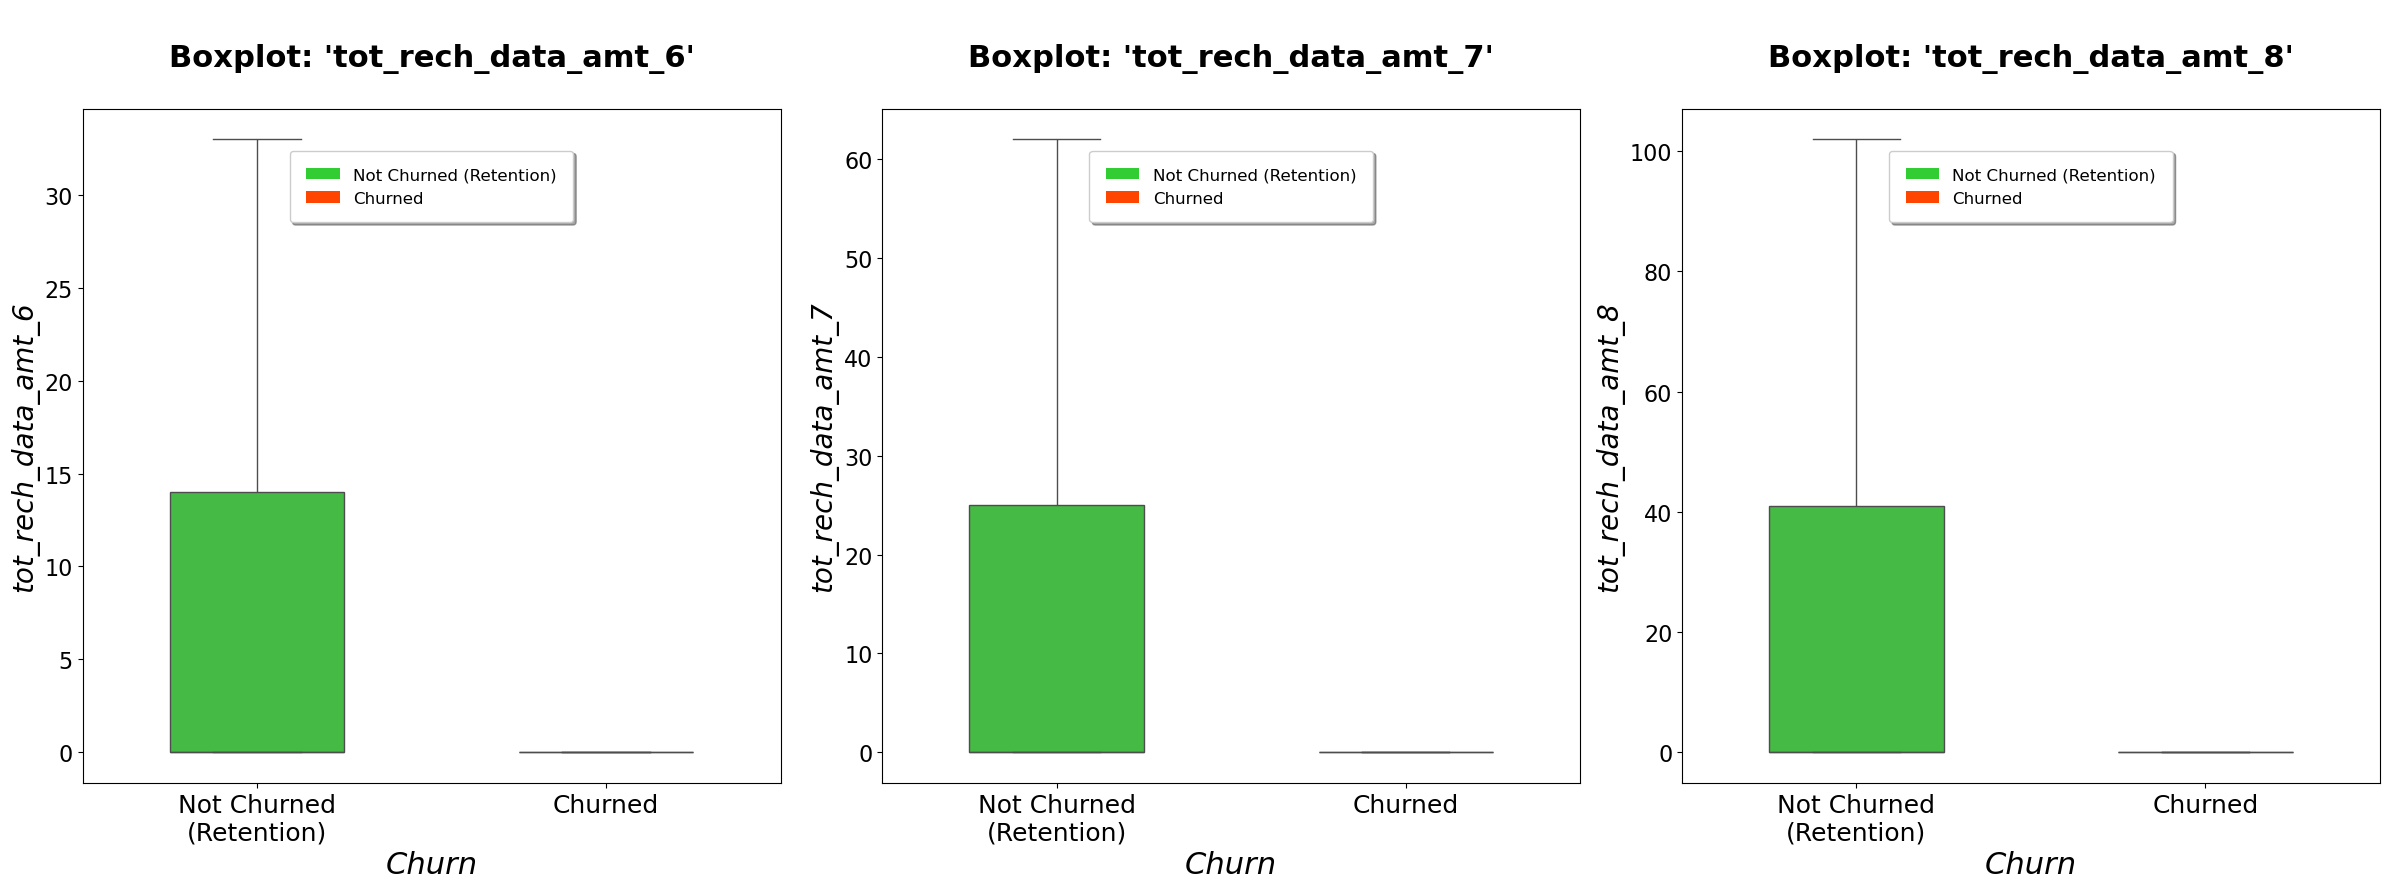

In [303]:
plot_boxplots_6_7_8("tot_rech_data_amt")

##General Observations

Outliers: There are no outliers present in the data for any of the months.
Churn vs. Non-Churn

Median: The median total data recharge amount for churned customers is generally lower than that for non-churned customers across all three months. This suggests that customers who churn tend to have lower data recharge amounts.
Distribution: The distribution of total data recharge amounts for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in tot_rech_data_amt_6. This indicates that churned customers exhibit a wider range of data recharge amounts.
Month-to-Month Comparison

tot_rech_data_amt_6: The median total data recharge amount for both churned and non-churned customers is highest in this month.
tot_rech_data_amt_7: There's a slight decrease in the median total data recharge amount for both groups compared to tot_rech_data_amt_6.
tot_rech_data_amt_8: The median total data recharge amount continues to decrease for both groups compared to the previous months.



In [305]:
usage_2g_3g_vars = list(data.columns[data.columns.str.contains('2g|3g',regex=True)]) 
# Creates a list called 'usage_2g_3g_vars' containing column names from 'data' that contain either "2g" or "3g".
null_prcnt_df(data[usage_2g_3g_vars]) 
# Calls the 'null_prcnt_df' function (defined earlier) on a DataFrame containing only 
# the 2G/3G usage columns to display the percentage of null values.

,Null_Percentage
count_rech_2g_6,74.902499
arpu_3g_6,74.902499
count_rech_3g_6,74.902499
arpu_2g_6,74.902499
count_rech_2g_7,74.478207
arpu_3g_7,74.478207
arpu_2g_7,74.478207
count_rech_3g_7,74.478207
count_rech_3g_8,73.689624
arpu_3g_8,73.689624


In [306]:
# Dropping 'arpu_2g', 'arpu_3g', 'count_rech_2g' and 'count_rech_3g' based features (revenue_based)
drop_vars = list(data.columns[data.columns.str.contains('arpu_2g|arpu_3g|count_rech_2g_|count_rech_3g')])
data.drop(drop_vars, axis=1, inplace=True)
unseen.drop(drop_vars, axis=1, inplace=True)

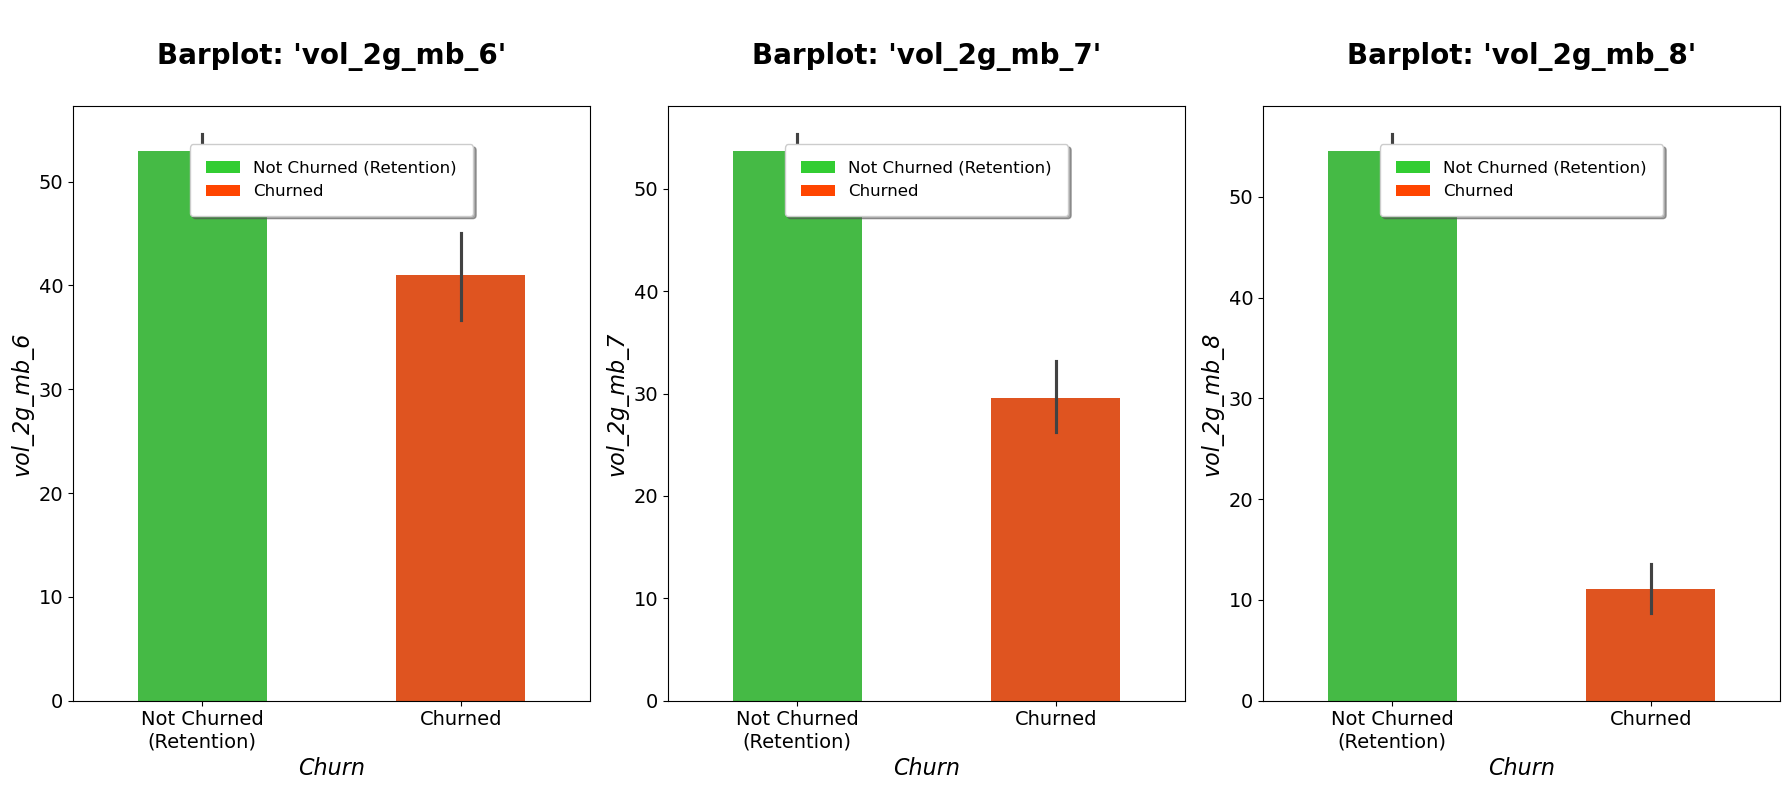

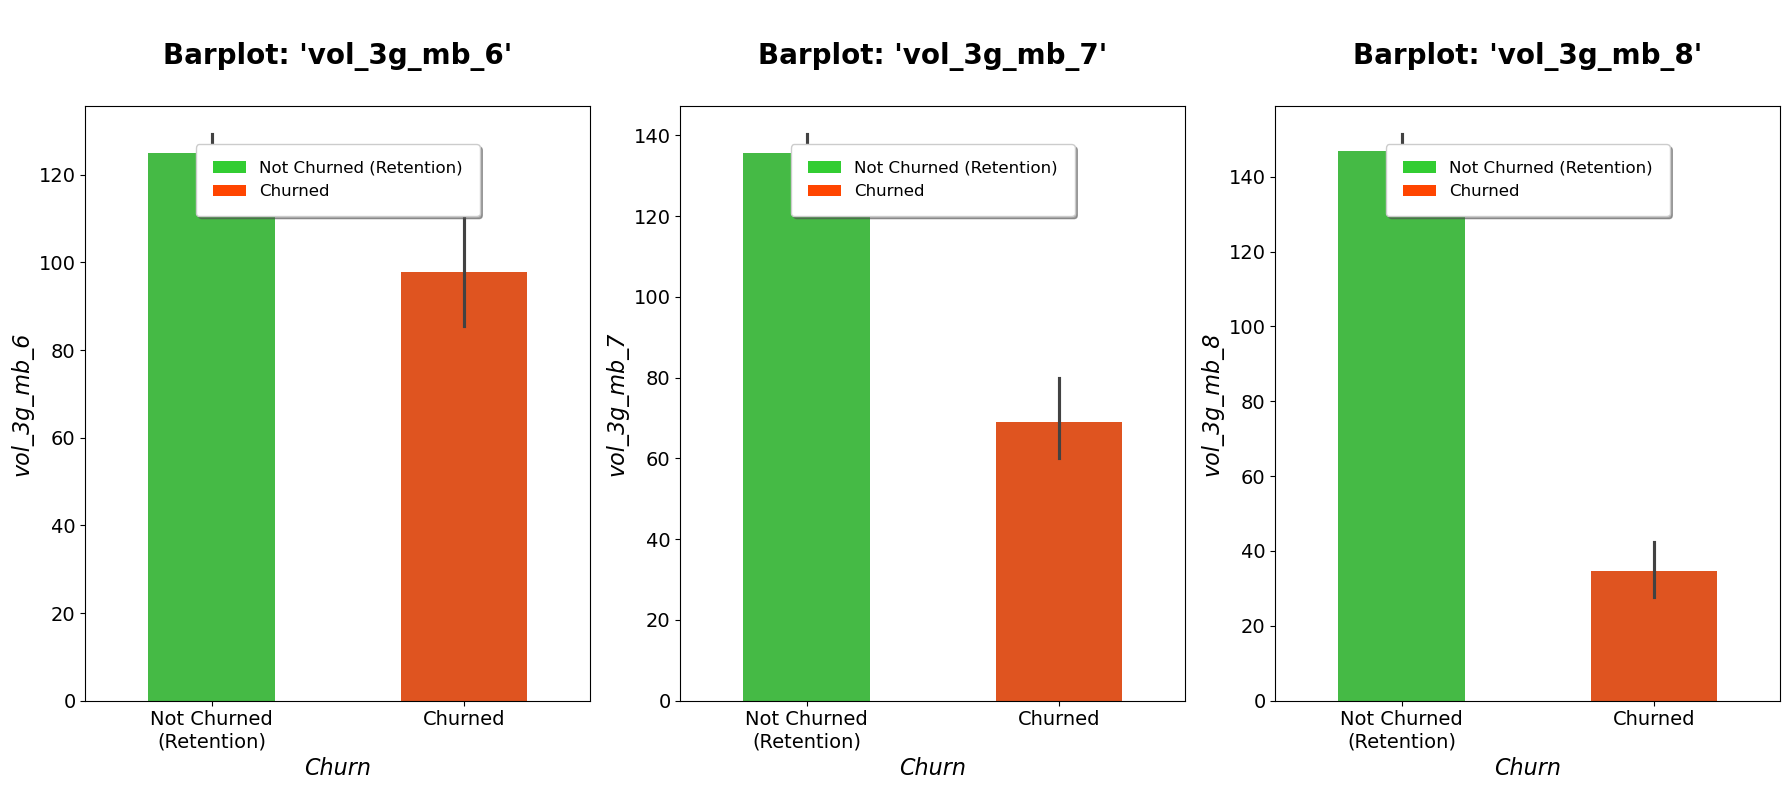

In [307]:
plot_barplots_6_7_8("vol_2g_mb")
plot_barplots_6_7_8("vol_3g_mb")

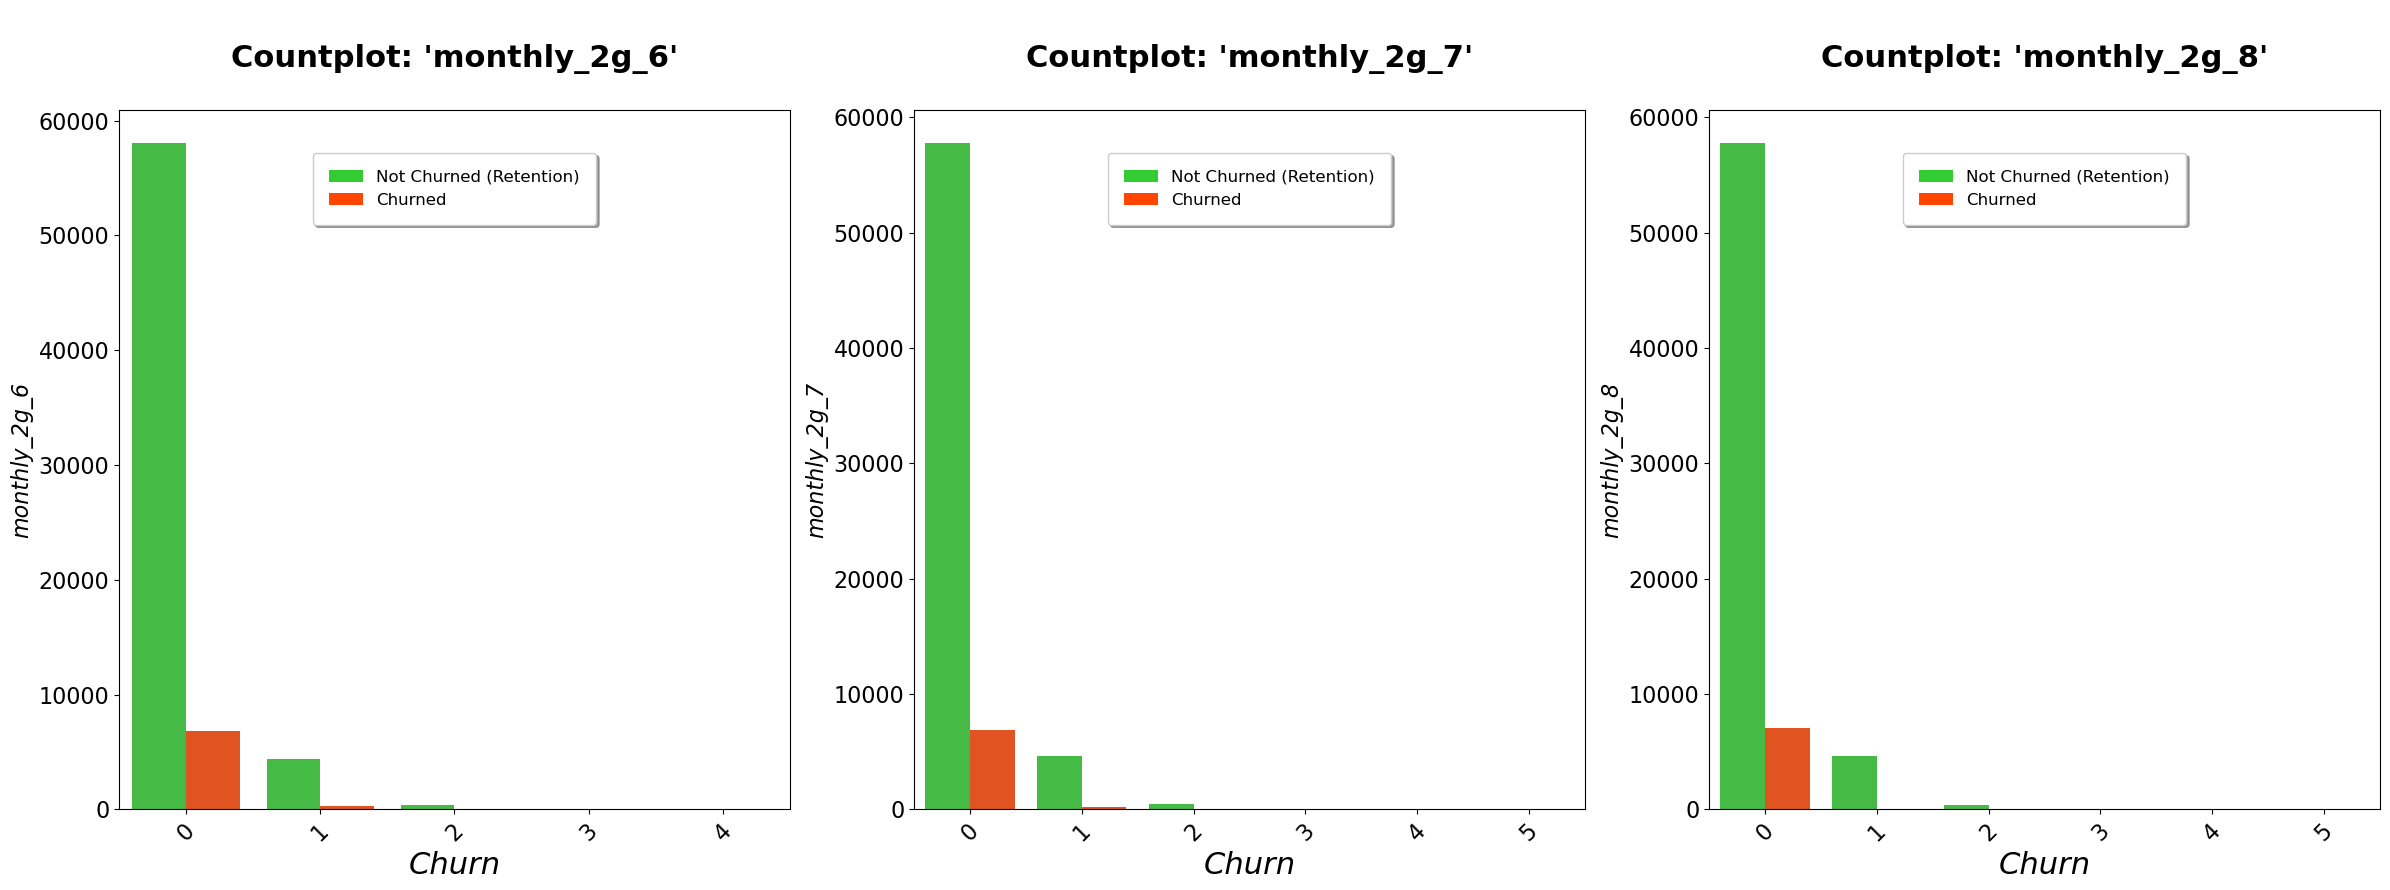

In [308]:
plot_countplots_6_7_8("monthly_2g")

##General Observations

Distribution: The distribution of monthly_2g usage is heavily skewed towards the lower end for both churned and non-churned customers in all three months. This suggests that a significant portion of customers have low or no 2G usage.
Churn vs. Non-Churn

Usage: The majority of customers in all three months, regardless of churn status, fall into the lowest usage categories (0-2).
Churn Proportion: The proportion of churned customers within each usage category is generally lower than the proportion of non-churned customers. This suggests that customers with higher monthly_2g usage might be less likely to churn.
Month-to-Month Comparison

Usage Patterns: The overall usage patterns seem to be relatively consistent across the three months.
Churn Proportion: The proportion of churned customers within each usage category appears to remain fairly stable across the months.
Possible Interpretations

Usage and Churn: While the relationship might not be straightforward, higher monthly_2g usage could be associated with a lower churn risk.

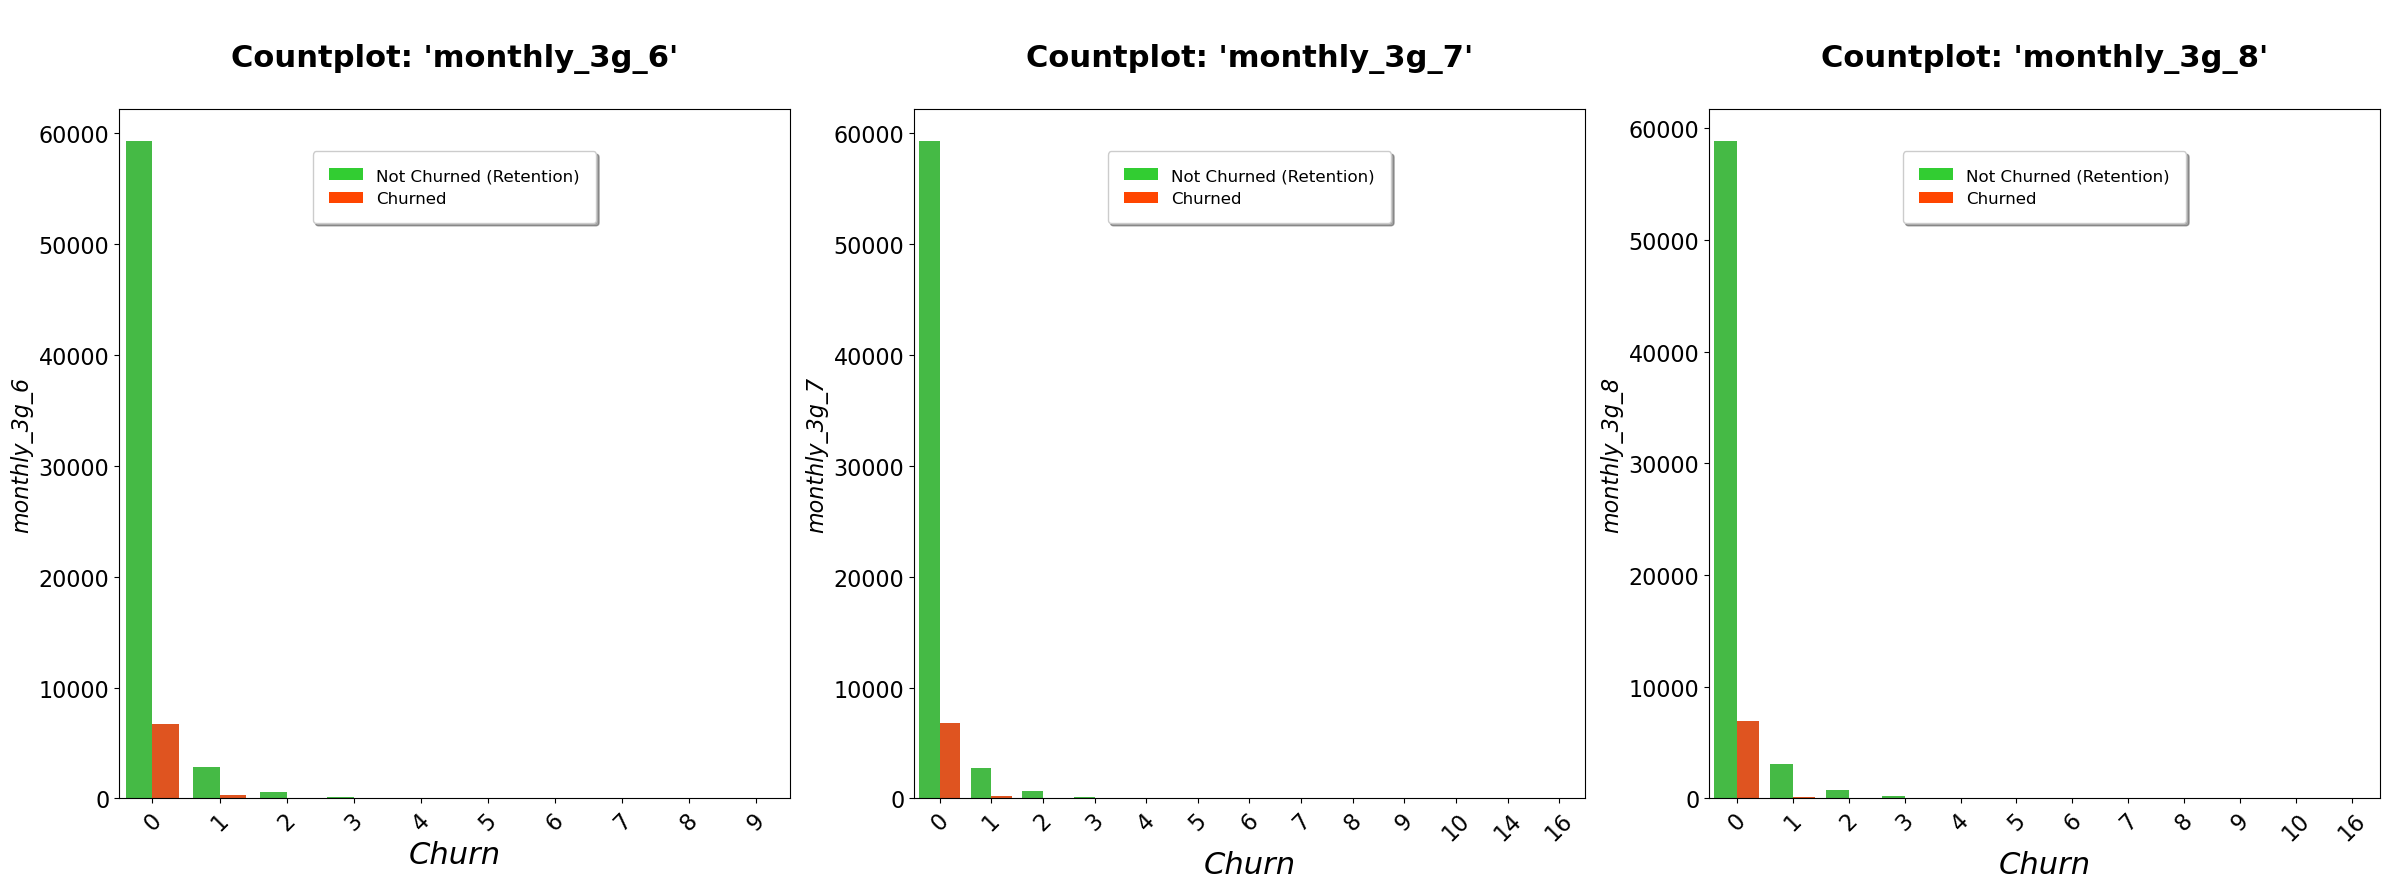

In [310]:
plot_countplots_6_7_8("monthly_3g")

##General Observations

Distribution: The distribution of monthly_3g usage is heavily skewed towards the lower end for both churned and non-churned customers in all three months. This suggests that a significant portion of customers have low or no 3G usage.
Churn vs. Non-Churn

Usage: The majority of customers in all three months, regardless of churn status, fall into the lowest usage categories (0-2).
Churn Proportion: The proportion of churned customers within each usage category is generally lower than the proportion of non-churned customers. This suggests that customers with higher monthly_3g usage might be less likely to churn.
Month-to-Month Comparison

Usage Patterns: The overall usage patterns seem to be relatively consistent across the three months.
Churn Proportion: The proportion of churned customers within each usage category appears to remain fairly stable across the months.
Possible Interpretations

Usage and Churn: While the relationship might not be straightforward, higher monthly_3g usage could be associated with a lower churn risk.

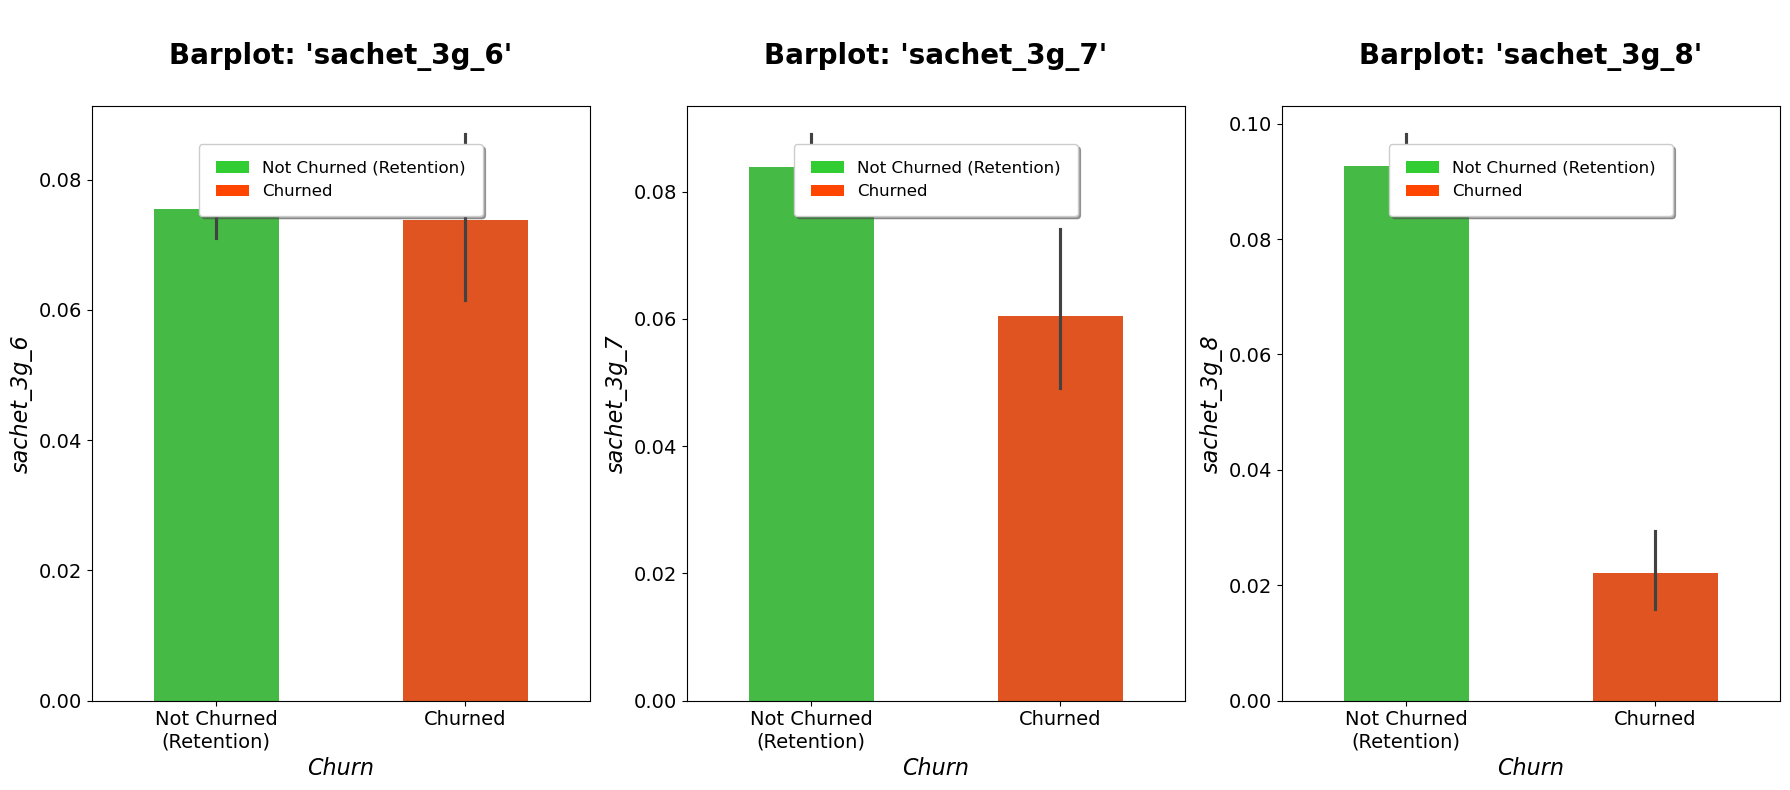

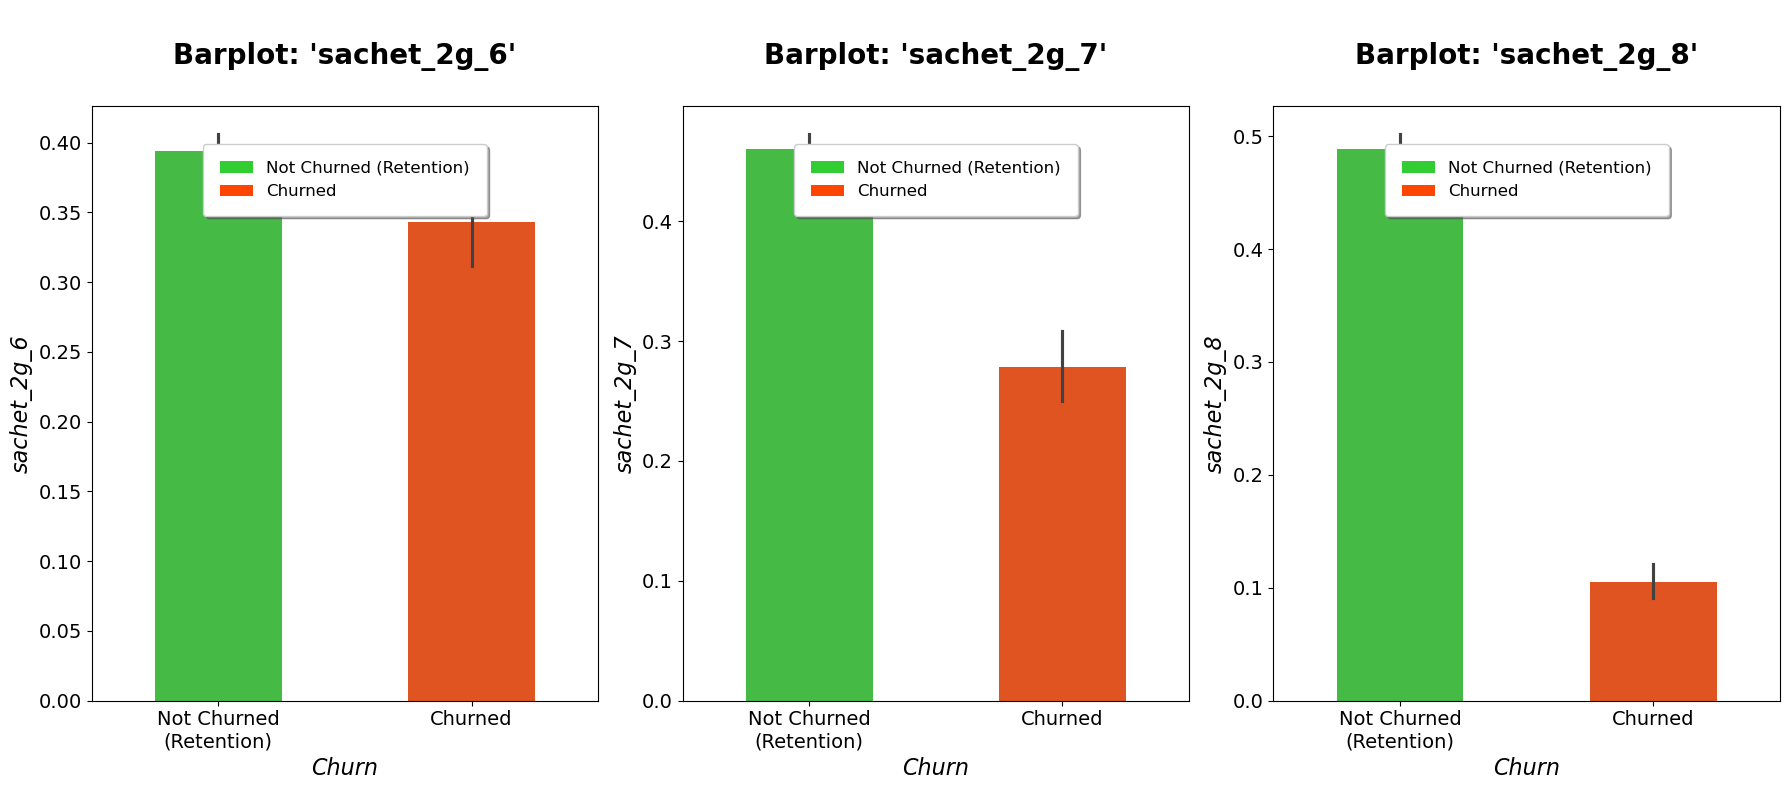

In [312]:
plot_barplots_6_7_8("sachet_3g")

plot_barplots_6_7_8("sachet_2g")

Tenure (Age on network) Analysis

The AON variable was used to create tenure buckets. [AON: Age on network (in number of days)]
It is observerd that larger the tenure, lesser was the churn - as customers who are newly acquired by the network churned more often in comparison to the old customers.

In [314]:
# Creating a new column tenure_year to store the number of years the customer has been on network T
data['tenure_year'] = round(data['aon']/365, 1) # Creates a new column 'tenure_year' in the 'data' DataFrame by dividing the 'aon' (age on network) column by 365 (days in a year) and rounding to 1 decimal place.
unseen['tenure_year'] = round(unseen['aon']/365, 1) # Creates a new column 'tenure_year' in the 'unseen' DataFrame by dividing the 'aon' column by 365 and rounding to 1 decimal place.
print(data.tenure_year.value_counts()) # Prints the frequency of each unique value in the 'tenure_year' column of the 'data' DataFrame.
print("Min:",data.tenure_year.min()) # Prints the minimum value in the 'tenure_year' column of the 'data' DataFrame.
print("Max:",data.tenure_year.max()) # Prints the maximum value in the 'tenure_year' column of the 'data' DataFrame.

tenure_year
1.3     3334
0.6     2531
0.8     2366
1.0     2316
0.9     2293
1.4     2221
0.7     2075
1.2     1963
1.1     1731
1.7     1586
1.5     1569
2.0     1536
0.5     1522
1.8     1491
1.9     1390
2.1     1270
1.6     1238
2.2     1130
2.4     1119
2.3     1117
2.6     1094
3.0     1014
2.9      993
2.8      987
2.5      971
10.0     932
2.7      881
6.5      880
8.5      822
3.1      784
3.2      775
3.3      770
3.4      727
3.6      713
3.5      673
3.7      663
3.8      590
7.1      581
3.9      579
4.6      557
6.6      546
4.0      542
4.2      529
6.9      472
6.8      458
4.7      454
7.6      452
4.1      441
6.2      439
4.3      438
7.0      436
7.9      435
6.4      427
6.7      425
7.5      418
8.0      399
7.2      396
8.1      392
7.8      387
4.4      379
4.9      375
4.5      374
5.5      371
5.4      370
6.1      367
6.3      357
5.0      352
7.7      345
7.4      340
8.4      337
8.8      333
4.8      328
5.3      323
5.7      317
8.3      305
5.8      302


In [315]:
#Creating bins
my_bins = [0,1,2,3,5,12] # Defines the bin edges for tenure years.
my_labels_aon= ['0_1_year','1_2_year','2_3_year','3_5_year','5_12_year'] # Defines the labels for each tenure bin.
data['tenure'] = pd.cut(data['tenure_year'], bins= my_bins, labels= my_labels_aon) # Creates a new column 'tenure' in the 'data' DataFrame by binning the 'tenure_year' column using the defined bins and labels.
unseen['tenure'] = pd.cut(unseen['tenure_year'], bins= my_bins, labels= my_labels_aon) # Creates a new column 'tenure' in the 'unseen' DataFrame by binning the 'tenure_year' column using the defined bins and labels.
#Dropping 'tenure_year' and 'aon' column as we have already created bins in 'tenure' column
data.drop(['tenure_year','aon'] , axis=1, inplace= True) # Drops the 'tenure_year' and 'aon' columns from the 'data' DataFrame in place.
unseen.drop(['tenure_year','aon'] , axis=1, inplace= True) # Drops the 'tenure_year' and 'aon' columns from the 'unseen' DataFrame in place.
data.tenure.value_counts() # Prints the frequency of each unique value (bin) in the 'tenure' column of the 'data' DataFrame.

tenure
1_2_year     18059
5_12_year    17218
0_1_year     13103
3_5_year     11043
2_3_year     10576
Name: count, dtype: int64

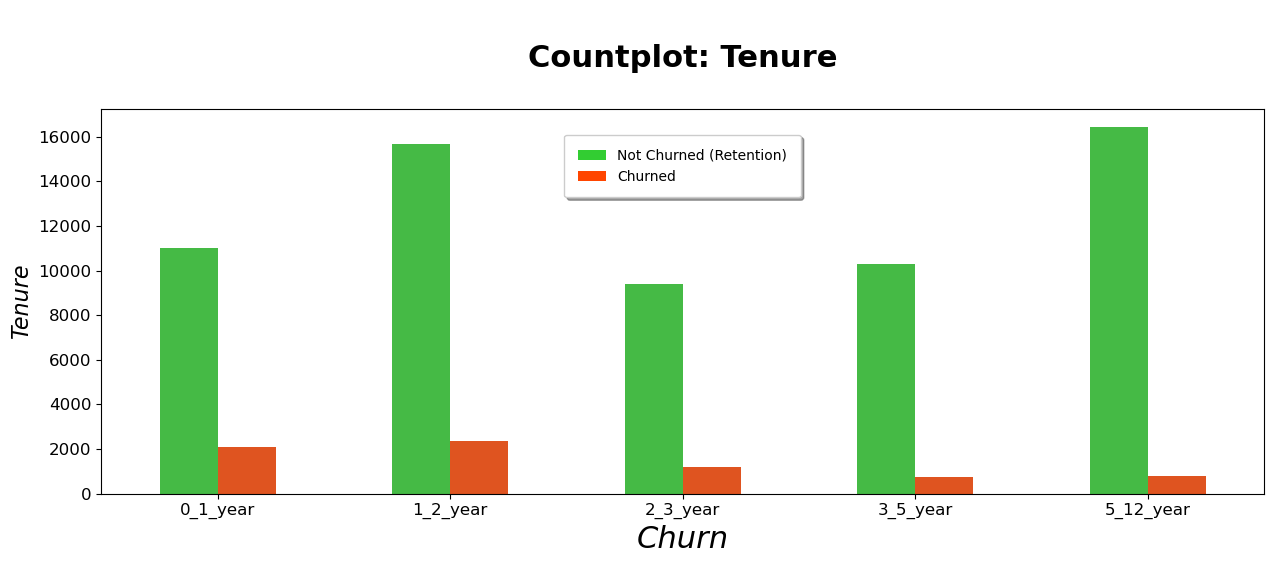

In [316]:
# Visualizing 'age of network' and 'churn_probability'
plt.figure(figsize=(15, 5))  # Creates a larger figure for better visualization
tenure_df = data[['tenure', 'churn_probability']]  # Creates a new DataFrame containing only 'tenure' and 'churn_probability' columns
colors = {"Not Churned": "#32CD32", "Churned": "#FF4500"}  # Defines a color dictionary for churn labels

# Create a countplot to visualize churn distribution across tenure groups
sns.countplot(
    x='tenure',  # Sets the x-axis variable ('tenure')
    hue='churn_probability',  # Sets the hue (color) based on 'churn_probability'
    data=tenure_df,  # Uses the newly created 'tenure_df' DataFrame
    palette=[colors["Not Churned"], colors["Churned"]],  # Sets the color palette for churn labels
    width=0.5  # Adjusts the width of the bars for better visibility
)

plt.title(f"\nCountplot: Tenure\n", fontsize=22, fontweight='bold')  # Sets the plot title
plt.ylabel("Tenure", fontsize=16, fontstyle='italic')  # Sets the y-axis label
plt.xlabel("Churn", fontsize=22, fontstyle='italic')  # Sets the x-axis label
plt.xticks(fontsize=12)  # Sets the x-axis tick label font size
plt.yticks(fontsize=12)  # Sets the y-axis tick label font size

# Create custom legend elements
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors["Not Churned"], label='Not Churned (Retention)'),
    Patch(facecolor=colors["Churned"], label='Churned'),
]
plt.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 0.95), fontsize=10,
          frameon=True, framealpha=1, shadow=True, borderpad=1, facecolor='white')  # Adds a legend

plt.show()  # Displays the plot

##Observations

Tenure and Churn: The chart illustrates a strong relationship between customer tenure and the probability of churn. As tenure increases, the number of customers who churn decreases significantly.

Early Churn: The highest proportion of churn occurs in the "0_1_year" category, indicating a significant number of customers churn within their first year of service.

Reduced Churn with Tenure: The proportion of churn decreases steadily as tenure increases, with the lowest churn rates observed in the "5_12_year" category. This suggests that customer loyalty increases over time.

Possible Interpretations

Customer Loyalty: The decreasing churn rate with increasing tenure could be attributed to customer loyalty building over time. Longer-tenure customers might be more satisfied with the service and less likely to switch providers.
Early Churn Drivers: Understanding the reasons behind early churn is crucial. Factors like initial service dissatisfaction, unmet expectations, or lack of engagement could be contributing to the high churn rate in the first year.
Retention Strategies: Targeted retention strategies could be implemented to address the high churn rate in the early stages. This might involve proactive outreach, personalized offers, or improved onboarding experiences.

In [318]:
#Since this is not a time-series based analysis, we might also eliminate date columns as they won't be useful for our analysis
date_columns_list = list(data.columns[data.columns.str.contains('date')]) # Creates a list called 'date_columns_list' containing column names from 'data' that contain the substring "date".
print("============================================================================================")
print("Columns containing Dates:", date_columns_list) # Prints the list of identified date columns.
#Dropping the date columns
print("============================================================================================")
data.drop(date_columns_list, axis=1, inplace=True) # Drops the columns listed in 'date_columns_list' from the 'data' DataFrame in place.
unseen.drop(date_columns_list, axis=1, inplace=True) # Drops the columns listed in 'date_columns_list' from the 'unseen' DataFrame in place.
data.head() # Displays the first few rows of the modified 'data' DataFrame to verify that the date columns have been dropped.

Columns containing Dates: ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']


,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,tot_rech_data_amt_6,tot_rech_data_amt_7,tot_rech_data_amt_8,av_rech_data_amt_6_7,tenure
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,65,65,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0,0.0,0.0,71.0,5_12_year
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,0,0,0,0.0,1.0,0.0,0.0,145.0,0.0,0.0,145.0,0.0,0.0,352.91,0.00,0.0,3.96,0.0,NaN,0.0,NaN,0,0,0,0,0,0,0,1,0,0,0,0,NaN,1.0,NaN,0.0,0.0,0.0,0,0.0,145.0,0.0,145.0,1_2_year
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.0,0.00,0.0,0.0,28.94,84.99,0.00,0.0,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.0,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,70,50,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,0

In [319]:
#Let's check for a record (i.e. index 21: example)
print("============================================================================================")
print("'loc_og_mou_6' = 'loc_og_t2t_mou_6' + 'loc_og_t2m_mou_6' + 'loc_og_t2f_mou_6'")
print(data.loc[21,'loc_og_mou_6'],"==",data.loc[21,['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6']].sum())
print("============================================================================================")
print("'std_og_mou_6' = 'std_og_t2t_mou_6' + 'std_og_t2m_mou_6' + 'std_og_t2f_mou_6'")
print(data.loc[21,'std_og_mou_6'],"==",data.loc[21,['std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6']].sum())
print("============================================================================================")
print("'total_og_mou_6' = 'loc_og_mou_6' + 'std_og_mou_6' +  'spl_og_mou_6' + 'isd_og_mou_6'")
print(data.loc[21,'total_og_mou_6'],"==",data.loc[21,['loc_og_mou_6','std_og_mou_6','spl_og_mou_6','isd_og_mou_6']].sum())
print("============================================================================================")

'loc_og_mou_6' = 'loc_og_t2t_mou_6' + 'loc_og_t2m_mou_6' + 'loc_og_t2f_mou_6'
191.74 == 191.74
'std_og_mou_6' = 'std_og_t2t_mou_6' + 'std_og_t2m_mou_6' + 'std_og_t2f_mou_6'
21.78 == 21.77
'total_og_mou_6' = 'loc_og_mou_6' + 'std_og_mou_6' +  'spl_og_mou_6' + 'isd_og_mou_6'
213.53 == 213.52


In [320]:
#Check for outgoing(og) mou features (just for 6th month)
og_mou_features = list(data.columns[data.columns.str.contains('.*_og_.*mou_6')])
og_mou_features

['roam_og_mou_6',
 'loc_og_t2t_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'spl_og_mou_6',
 'total_og_mou_6']

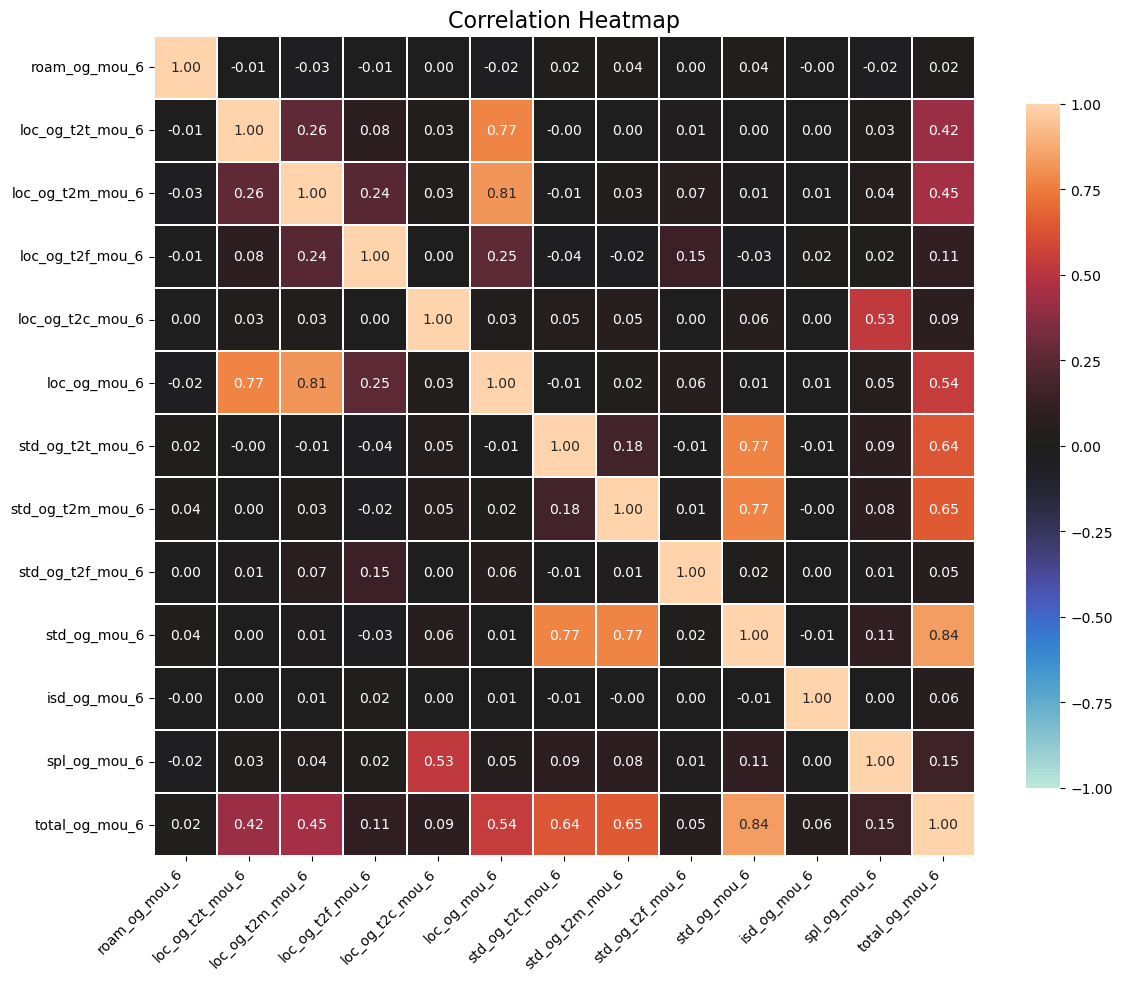

In [321]:
# Let's check the correlation between these variables to see if there is pattern between variables

def plot_correlation_heatmap(data, features, title="Correlation Heatmap"):
    """
    Creates a heatmap visualization of the correlation matrix for a subset of features in a DataFrame.

    Args:
        data (pandas.DataFrame): The DataFrame containing the data.
        features (list): A list of feature names to include in the correlation analysis.
        title (str, optional): The title for the heatmap plot. Defaults to "Correlation Heatmap".
    """

    corr = data[features].corr(numeric_only=True)  # Calculates pairwise correlation for numeric features

    # Define a custom color palette (optional)
    colors = ["#3498db", "#e74c3c"]

    plt.figure(figsize=(12, 10))  
    ax = sns.heatmap(
        corr, 
        cbar_kws={"shrink": 0.8},  
        vmin=-1, vmax=1, center=0, square=True, 
        annot=True, linewidths=0.1, annot_kws={"size": 10}, fmt=".2f"  
    )
    plt.title(title, fontsize=16)  
    plt.xticks(rotation=45, ha='right') 
    plt.yticks(rotation=0)  
    plt.tight_layout() 
    plt.show()  

plot_correlation_heatmap(data, og_mou_features)  # Calls the function with the 'data' DataFrame and 'og_mou_features' list

In [322]:
#Dropping 'loc_og_mou', 'std_og_mou' and 'total_og_mou' for all 3 months
drop_og_mou_features = list(data.columns[data.columns.str.contains('loc_og_mou_|std_og_mou_|total_og_mou_')]) # Creates a list called 'drop_og_mou_features' containing column names from 'data' that contain 'loc_og_mou_', 'std_og_mou_', or 'total_og_mou_'.
print("============================================================================================")
print('List of features dropped:\n', drop_og_mou_features) # Prints the list of features that will be dropped.

data.drop(drop_og_mou_features, axis=1, inplace=True) # Drops the columns listed in 'drop_og_mou_features' from the 'data' DataFrame in place.
unseen.drop(drop_og_mou_features, axis=1, inplace=True) # Drops the columns listed in 'drop_og_mou_features' from the 'unseen' DataFrame in place.
print("============================================================================================") # Prints a separator for visual clarity.

List of features dropped:
 ['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']


In [323]:
#Check for incoming(ic) mou features (just for 6th month)
ic_mou_features = list(data.columns[data.columns.str.contains('.*_ic_.*mou_6')])
ic_mou_features

['roam_ic_mou_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_mou_6',
 'total_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6']

In [324]:
data[ic_mou_features].describe()

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6
count,67231.000000,67231.000000,67231.000000,67231.000000,67231.000000,67231.000000,67231.000000,67231.000000,67231.000000,69999.000000,67231.000000,67231.000000
mean,9.765435,48.043255,107.152439,12.050672,167.255126,9.476958,20.734858,2.146273,32.360632,199.710640,0.061932,7.394167
std,57.374429,140.499757,168.455999,39.416076,252.576231,51.664472,80.294236,16.522232,104.381082,290.114823,0.164823,60.951165
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.030000,17.390000,0.000000,30.630000,0.000000,0.000000,0.000000,0.000000,38.640000,0.000000,0.000000
50%,0.000000,15.740000,56.460000,0.880000,92.430000,0.000000,2.040000,0.000000,5.910000,114.780000,0.000000,0.000000
75%,0.000000,46.980000,132.020000,8.140000,208.325000,4.060000,14.960000,0.000000,26.780000,251.070000,0.000000,0.000000
max,2850.980000,5315.590000,4450.740000,1872.340000,7454.630000,3336.380000,5647.160000,1351.110000,5712.110000,7716.140000,19.760000,6789.410000


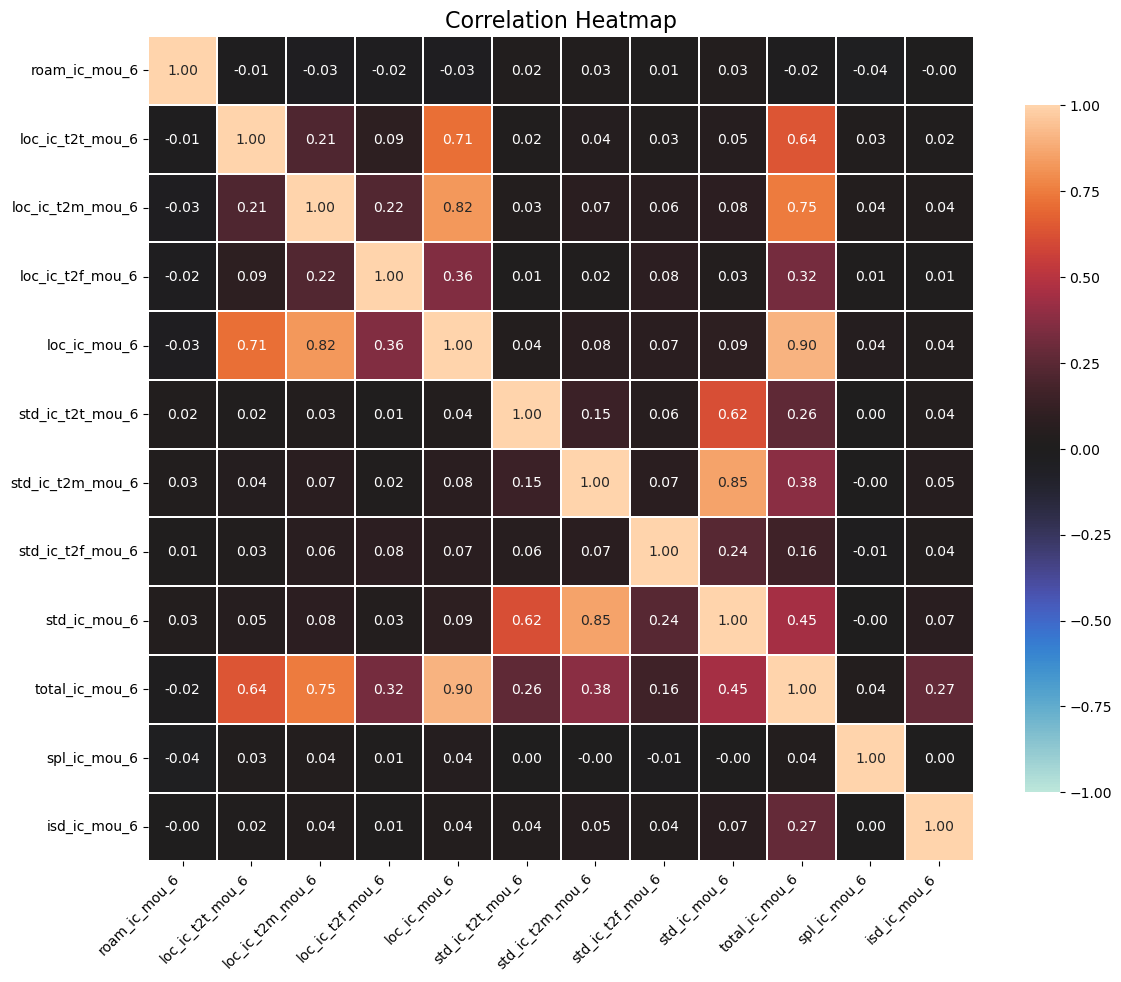

In [325]:
plot_correlation_heatmap(data, ic_mou_features)

In [326]:
#Let's check for a record (i.e. index 10: example)
print("============================================================================================")
print("'loc_ic_mou_6' = 'loc_ic_t2t_mou_6' + 'loc_ic_t2m_mou_6' + 'loc_ic_t2f_mou_6'")
print(data.loc[10,'loc_ic_mou_6'],"==",data.loc[10,['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6']].sum())
print("============================================================================================")
print("'std_ic_mou_6' = 'std_ic_t2t_mou_6' + 'std_ic_t2m_mou_6' + 'std_ic_t2f_mou_6'")
print(data.loc[10,'std_ic_mou_6'],"==",data.loc[10,['std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6']].sum())
print("============================================================================================")
print("'total_ic_mou_6' = 'loc_ic_mou_6' + 'std_ic_mou_6' + 'isd_ic_mou_6' + 'spl_ic_mou_6'")
print(data.loc[10,'total_ic_mou_6'],"==",data.loc[10,['loc_ic_mou_6','std_ic_mou_6','isd_ic_mou_6', 'spl_ic_mou_6']].sum())
print("============================================================================================")

'loc_ic_mou_6' = 'loc_ic_t2t_mou_6' + 'loc_ic_t2m_mou_6' + 'loc_ic_t2f_mou_6'
140.69 == 140.68
'std_ic_mou_6' = 'std_ic_t2t_mou_6' + 'std_ic_t2m_mou_6' + 'std_ic_t2f_mou_6'
444.79 == 444.79
'total_ic_mou_6' = 'loc_ic_mou_6' + 'std_ic_mou_6' + 'isd_ic_mou_6' + 'spl_ic_mou_6'
585.49 == 585.48


In [327]:
#Dropping 'loc_ic_mou', 'std_ic_mou' and 'total_ic_mou' for all 3 months
drop_ic_mou_features = list(data.columns[data.columns.str.contains('loc_ic_mou_|std_ic_mou_|total_ic_mou_')]) # Creates a list called 'drop_ic_mou_features' containing column names from 'data' that contain 'loc_ic_mou_', 'std_ic_mou_', or 'total_ic_mou_'.
print("============================================================================================")
print('List of features dropped:\n', drop_ic_mou_features) # Prints the list of features that will be dropped.

data.drop(drop_ic_mou_features, axis=1, inplace=True) 
unseen.drop(drop_ic_mou_features, axis=1, inplace=True) 
print("============================================================================================") 

List of features dropped:
 ['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']


In [328]:
#Check for missing values in data dataframe (show only missing value columns)
missing_val_cols_prcnt = round(100*data.isnull().sum()/len(data.index),2) 

# Creates a new DataFrame 'missing' containing only the columns with non-zero missing value percentages, 
# sorted in descending order. Resets the index of the 'missing' DataFrame and modifies it in place.
missing = pd.DataFrame(missing_val_cols_prcnt[missing_val_cols_prcnt!=0].sort_values(ascending=False)) 
missing.reset_index(inplace=True) 

missing = missing.rename(columns={'index':'features',0:'Null_Percentage'}) 
missing 

,features,Null_Percentage
0,night_pck_user_6,74.90
1,fb_user_6,74.90
2,night_pck_user_7,74.48
3,fb_user_7,74.48
4,night_pck_user_8,73.69
5,fb_user_8,73.69
6,isd_og_mou_8,5.29
7,og_others_8,5.29
8,loc_ic_t2t_mou_8,5.29
9,loc_og_t2f_mou_8,5.29


**Observation:** <br>(i) Since we checked at the very beginning that `'fb_user_*''` and `'night_pck_user_*'` attributes had same number of missing values as the dates of recharging data plan. Thus, the number of missing values, imply no recharge done. However, 0 has a meaning here, we just can't impute with 0. Also, a lot of values are missing (46.8%) and these features don't seem to be significant. Hence, dropping the `'fb_user_*''` and `'night_pck_user_*'` attributes

In [330]:
#Dropping 'fb_user_*' and 'night_pck_user_*' features
cols_to_drop = ['fb_user_6', 'fb_user_7', 'fb_user_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']
data.drop(cols_to_drop, axis=1, inplace= True)
unseen.drop(cols_to_drop, axis=1, inplace= True)

In [331]:
#Imputing 'ic_others' and 'og_others' with 0 (<=3.91% missing values)
# Creates a list-like object 'cols_to_impute' containing column names from 'data' that contain 
# 'ic_others', 'og_others', '_7', '_6', or '_8'.
cols_to_impute = data.columns[data.columns.str.contains('ic_others|og_others|_7|_6|_8')] 
data[cols_to_impute] = data[cols_to_impute].replace(np.nan, 0) 
cols_to_impute_2 = unseen.columns[unseen.columns.str.contains('ic_others|og_others|_7|_6|_8')] 
unseen[cols_to_impute_2] = unseen[cols_to_impute_2].replace(np.nan, 0)

In [332]:
null_prcnt_df(data)

,Null_Percentage
id,0.000000
std_ic_t2f_mou_6,0.000000
max_rech_data_7,0.000000
max_rech_data_6,0.000000
total_rech_data_8,0.000000
total_rech_data_7,0.000000
total_rech_data_6,0.000000
last_day_rch_amt_8,0.000000
last_day_rch_amt_7,0.000000
last_day_rch_amt_6,0.000000


In [333]:
#Features in data corresponding to 'month_6'
attributes_6 = list(data.columns[data.columns.str.contains("_6")])
print("============================================================================================")
print(attributes_6)
print("Total no of attribues for the month of June: ",len(attributes_6))
print("============================================================================================")
#Features in data corresponding to 'month_7'
attributes_7 = list(data.columns[data.columns.str.contains("_7")])
print(attributes_7)
print("Total no of attribues for the month of July: ",len(attributes_7))
print("============================================================================================")

['arpu_6', 'onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6', 'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6', 'last_day_rch_amt_6', 'total_rech_data_6', 'max_rech_data_6', 'av_rech_amt_data_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'monthly_2g_6', 'sachet_2g_6', 'monthly_3g_6', 'sachet_3g_6', 'tot_rech_data_amt_6', 'av_rech_data_amt_6_7']
Total no of attribues for the month of June:  39
['arpu_7', 'onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'isd_og_mou_7', 'spl_og_

In [334]:
#Firstly, let's drop 'avg_total_rech_plus_data_amt_6_7'
data.drop('av_rech_data_amt_6_7', axis=1, inplace= True)

#Let's combine and take average of remaining '_6'  and '_7' attributes
feature_names_6 = [i.split('_6')[0] for i in attributes_6 if i.endswith("_6")]
feature_names_7 = [i.split('_7')[0] for i in attributes_7 if i.endswith("_7")]

In [335]:
uncommon_feature_names = [i for i,j in (zip(feature_names_6, feature_names_7)) if i!=j]
print("============================================================================================")
print("uncommon_feature_names: ",uncommon_feature_names)
print("============================================================================================")
common_feature_names= [i for i,j in (zip(feature_names_6, feature_names_7)) if i==j]
print("common_feature_names: ",common_feature_names)
print("============================================================================================")

uncommon_feature_names:  []
common_feature_names:  ['arpu', 'onnet_mou', 'offnet_mou', 'roam_ic_mou', 'roam_og_mou', 'loc_og_t2t_mou', 'loc_og_t2m_mou', 'loc_og_t2f_mou', 'loc_og_t2c_mou', 'std_og_t2t_mou', 'std_og_t2m_mou', 'std_og_t2f_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 'loc_ic_t2t_mou', 'loc_ic_t2m_mou', 'loc_ic_t2f_mou', 'std_ic_t2t_mou', 'std_ic_t2m_mou', 'std_ic_t2f_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others', 'total_rech_num', 'total_rech_amt', 'max_rech_amt', 'last_day_rch_amt', 'total_rech_data', 'max_rech_data', 'av_rech_amt_data', 'vol_2g_mb', 'vol_3g_mb', 'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g', 'tot_rech_data_amt']


In [336]:
#Since all features of '_6' exist in '_7'. Therefore let's find the new 'avg_6_7' features
#(together representing the good phase)
f6_cols, f7_cols=[], []
feature_6, feature_7=[], []

for feature in common_feature_names:
    f6= feature+'_6'
    f7= feature+'_7'
    avg_67= feature+'_avg_67'

    f6_cols.append(f6)  #Storing all remaining attributes from '_6'
    f7_cols.append(f7)  #Storing all remaining attributes from '_7'

    data[avg_67] = (data[f6] + data[f7])/2
    if f6 in unseen.columns:
        feature_6.append(f6)
        feature_7.append(f7) 
        unseen[avg_67] = (unseen[f6] + unseen[f7])/2
    
data.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,tot_rech_data_amt_6,tot_rech_data_amt_7,tot_rech_data_amt_8,tenure,arpu_avg_67,onnet_mou_avg_67,offnet_mou_avg_67,roam_ic_mou_avg_67,roam_og_mou_avg_67,loc_og_t2t_mou_avg_67,loc_og_t2m_mou_avg_67,loc_og_t2f_mou_avg_67,loc_og_t2c_mou_avg_67,std_og_t2t_mou_avg_67,std_og_t2m_mou_avg_67,std_og_t2f_mou_avg_67,isd_og_mou_avg_67,spl_og_mou_avg_67,og_others_avg_67,loc_ic_t2t_mou_avg_67,loc_ic_t2m_mou_avg_67,loc_ic_t2f_mou_avg_67,std_ic_t2t_mou_avg_67,std_ic_t2m_mou_avg_67,std_ic_t2f_mou_avg_67,spl_ic_mou_avg_67,isd_ic_mou_avg_67,ic_others_avg_67,total_rech_num_avg_67,total_rech_amt_avg_67,max_rech_amt_avg_67,last_day_rch_amt_avg_67,total_rech_data_avg_67,max_rech_data_avg_67,av_rech_amt_data_avg_67,vol_2g_mb_avg_67,vol_3g_mb_avg_67,monthly_2g_avg_67,sachet_2g_avg_67,monthly_3g_avg_67,sachet_3g_avg_67,tot_rech_data_amt_avg_67
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,65,65,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,5_12_year,59.1430,86.480,64.460,0.00,0.000,1.115,10.665,0.00,0.000,85.36,49.680,0.00,0.0,4.415,0.19,3.055,10.955,0.000,3.805,13.710,0.0,0.0,0.0,0.9,2.5,71.0,65.0,65.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,0,0,0,0.0,1.0,0.0,0.0,145.0,0.0,0.0,145.0,0.0,0.0,352.91,0.00,0.0,3.96,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0,0.0,145.0,0.0,1_2_year,61.3935,0.000,12.995,0.00,0.000,0.000,0.000,0.00,11.005,0.00,0.000,0.00,0.0,15.365,0.00,10.385,10.045,1.005,0.000,0.000,0.0,0.0,0.0,0.0,3.5,72.5,72.5,0.0,0.5,72.5,72.5,176.455,1.98,0.0,0.0,0.5,0.0,72.5
2,2,60.806,103.17

In [337]:
#Dropping the fundamental explanatory variables belonging to '_6'
data.drop(f6_cols, axis=1, inplace=True)
unseen.drop(feature_6, axis=1, inplace=True)
#Dropping the fundamental explanatory variables belonging to '_7'
data.drop(f7_cols, axis=1, inplace=True)
unseen.drop(feature_7, axis=1, inplace=True)
data.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,tot_rech_data_amt_8,tenure,arpu_avg_67,onnet_mou_avg_67,offnet_mou_avg_67,roam_ic_mou_avg_67,roam_og_mou_avg_67,loc_og_t2t_mou_avg_67,loc_og_t2m_mou_avg_67,loc_og_t2f_mou_avg_67,loc_og_t2c_mou_avg_67,std_og_t2t_mou_avg_67,std_og_t2m_mou_avg_67,std_og_t2f_mou_avg_67,isd_og_mou_avg_67,spl_og_mou_avg_67,og_others_avg_67,loc_ic_t2t_mou_avg_67,loc_ic_t2m_mou_avg_67,loc_ic_t2f_mou_avg_67,std_ic_t2t_mou_avg_67,std_ic_t2m_mou_avg_67,std_ic_t2f_mou_avg_67,spl_ic_mou_avg_67,isd_ic_mou_avg_67,ic_others_avg_67,total_rech_num_avg_67,total_rech_amt_avg_67,max_rech_amt_avg_67,last_day_rch_amt_avg_67,total_rech_data_avg_67,max_rech_data_avg_67,av_rech_amt_data_avg_67,vol_2g_mb_avg_67,vol_3g_mb_avg_67,monthly_2g_avg_67,sachet_2g_avg_67,monthly_3g_avg_67,sachet_3g_avg_67,tot_rech_data_amt_avg_67
0,0,7.527,1.29,2.33,0.0,0.00,0.28,2.33,0.00,0.00,1.01,0.0,0.0,0.0,0.00,0.0,7.79,16.91,0.00,0.21,14.96,0.0,0.66,0.0,0.00,2,10,10,0,0.0,0.0,0.0,0.00,0.0,0,0,0,0,0.0,0.0,0.0,0,0.0,5_12_year,59.1430,86.480,64.460,0.00,0.000,1.115,10.665,0.00,0.000,85.36,49.680,0.00,0.0,4.415,0.19,3.055,10.955,0.000,3.805,13.710,0.0,0.0,0.0,0.9,2.5,71.0,65.0,65.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0
1,1,42.953,0.00,30.89,0.0,0.00,0.00,0.00,0.00,29.79,0.00,0.0,0.0,0.0,31.66,0.0,10.53,11.09,3.40,0.00,0.00,0.0,0.01,0.0,0.00,5,50,50,0,0.0,0.0,0.0,0.00,0.0,0,0,0,0,0.0,0.0,0.0,0,0.0,1_2_year,61.3935,0.000,12.995,0.00,0.000,0.000,0.000,0.00,11.005,0.00,0.000,0.00,0.0,15.365,0.00,10.385,10.045,1.005,0.000,0.000,0.0,0.0,0.0,0.0,3.5,72.5,72.5,0.0,0.5,72.5,72.5,176.455,1.98,0.0,0.0,0.5,0.0,72.5
2,2,0.000,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,6.49,23.51,0.00,0.00,6.38,0.0,0.00,0.0,0.25,2,0,0,0,0.0,0.0,0.0,0.00,0.0,0,0,0,0,0.0,0.0,0.0,0,0.0,2_3_year,81.9910,8.230,68.020,0.00,0.000,6.755,12.055,0.00,1.070,1.47,55.495,0.00,0.0,2.135,0.00,5.335,57.520,0.000,5.845,10.345,0.0,0.0,0.0,0.0,3.0,95.0,70.0,60.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0
3,3,111.095,0.00,50.23,0.0,1.63,0.00,23.63,0.00,8.03,0.00,4.6,0.0,0.0,25.61,0.0,23.88,57.14,0.00,0.00,2.81,0.0,0.00,0.0,0.00,3,130,50,50,0.0,0.0,0.0,0.00,0.0,0,0,0,0,0.0,0.0,0.0,0,0.0,2_3_year,180.8110,11.635,73.620,0.00,0.000,5.465,41.400,0.00,0.000,6.16,20.630,0.28,0.0,12.040,0.00,14.910,49.110,4.020,0.000,4.585,0.0,0.0,0.0,0.0,3.0,200.0,110.0,110.0,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0
4,4,101.565,6.13,9.63,0.0,0.00,6.13,4.61,5.01,0.00,0.00,0.0,0.0,0.0,0.00,0.0,2.66,19.49,6.14,0.00,0.00,0.0,0.00,0.0,0.00,8,122,30,30,6.0,25.0,142.0,213.47,0.0,0,6,0,0,0.0,0.0,0.0,0,852.0,1_2_year,184.4495,13.055,47.550,26.82,7.865,7.495,28.310,6.61,4.925,0.00,2.175,0.00,0.0,8.500,0.00,3.415,7.455,4.570,0.000,0.000,0.0,0.0,0.0,0.0,11.5,213.0,45.5,17.5,7.0,33.0,183.0,349.845,0.00,0.0,6.5,0.0,0.5,1281.0


In [338]:
unseen.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,tenure,arpu_avg_67,onnet_mou_avg_67,offnet_mou_avg_67,roam_ic_mou_avg_67,roam_og_mou_avg_67,loc_og_t2t_mou_avg_67,loc_og_t2m_mou_avg_67,loc_og_t2f_mou_avg_67,loc_og_t2c_mou_avg_67,std_og_t2t_mou_avg_67,std_og_t2m_mou_avg_67,std_og_t2f_mou_avg_67,isd_og_mou_avg_67,spl_og_mou_avg_67,og_others_avg_67,loc_ic_t2t_mou_avg_67,loc_ic_t2m_mou_avg_67,loc_ic_t2f_mou_avg_67,std_ic_t2t_mou_avg_67,std_ic_t2m_mou_avg_67,std_ic_t2f_mou_avg_67,spl_ic_mou_avg_67,isd_ic_mou_avg_67,ic_others_avg_67,total_rech_num_avg_67,total_rech_amt_avg_67,max_rech_amt_avg_67,last_day_rch_amt_avg_67,total_rech_data_avg_67,max_rech_data_avg_67,av_rech_amt_data_avg_67,vol_2g_mb_avg_67,vol_3g_mb_avg_67,monthly_2g_avg_67,sachet_2g_avg_67,monthly_3g_avg_67,sachet_3g_avg_67
0,69999,64.445,23.11,34.83,0.00,0.00,21.06,8.36,0.00,0.03,2.05,26.43,0.0,0.0,0.03,0.0,21.98,9.53,0.00,0.00,4.34,0.00,0.39,0.00,0.00,4,60,30,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.00,0.00,0.00,3_5_year,78.6060,26.005,46.160,0.000,0.000,22.555,14.510,6.790,0.00,3.45,24.855,0.0,0.0,0.000,0.0,33.945,7.400,0.130,0.000,0.700,0.0,0.44,0.000,0.0,5.0,96.5,40.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,70000,360.868,19.84,394.94,0.00,0.00,19.84,377.26,0.00,0.00,0.00,17.68,0.0,0.8,0.00,0.0,2.61,184.81,0.00,0.00,0.00,0.00,0.00,94.23,0.00,5,500,250,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.00,0.00,0.00,5_12_year,464.8680,58.360,548.090,0.000,0.000,58.360,535.845,0.365,0.00,0.00,11.880,0.0,0.0,0.000,0.0,23.470,141.240,0.745,0.000,6.255,0.0,0.00,146.255,0.0,4.5,500.0,250.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,70001,746.239,8.40,45.04,26.08,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5,1000,500,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,525.61,758.41,241.84,0_1_year,382.3640,7.700,31.395,63.095,39.105,0.000,0.000,0.000,0.00,0.00,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.000,0.0,7.5,750.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,70002,24.400,0.00,24.01,0.00,0.00,0.00,20.51,2.35,0.00,0.00,0.00,0.0,0.0,1.15,0.0,23.04,506.94,1.64,0.00,8.83,0.00,0.00,8.65,0.00,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.00,0.00,0.00,3_5_year,107.4700,3.735,122.525,0.000,0.000,2.655,50.775,0.000,3.09,1.08,65.725,0.0,0.0,6.015,0.0,56.375,468.885,0.190,2.130,10.755,0.0,0.00,0.715,0.0,4.0,185.0,130.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,70003,413.329,700.68,74.16,0.00,0.00,14.56,10.94,0.00,0.00,686.11,63.18,0.0,0.0,4.96,0.0,9.91,7.69,0.00,107.39,32.46,1.61,0.00,0.00,0.16,8,546,130,130,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.00,0.00,0.00,1_2_year,356.5715,529.980,42.390,0.000,0.000,0.615,2.525,0.000,0.00,529.36,39.860,0.0,0.0,3.050,1.1,0.180,9.680,0.000,61.035,13.920,0.0,0.00,0.000,0.0,9.0,423.0,110.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [339]:
data.shape

(69999, 82)

In [340]:
data.describe(percentiles= [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,tot_rech_data_amt_8,arpu_avg_67,onnet_mou_avg_67,offnet_mou_avg_67,roam_ic_mou_avg_67,roam_og_mou_avg_67,loc_og_t2t_mou_avg_67,loc_og_t2m_mou_avg_67,loc_og_t2f_mou_avg_67,loc_og_t2c_mou_avg_67,std_og_t2t_mou_avg_67,std_og_t2m_mou_avg_67,std_og_t2f_mou_avg_67,isd_og_mou_avg_67,spl_og_mou_avg_67,og_others_avg_67,loc_ic_t2t_mou_avg_67,loc_ic_t2m_mou_avg_67,loc_ic_t2f_mou_avg_67,std_ic_t2t_mou_avg_67,std_ic_t2m_mou_avg_67,std_ic_t2f_mou_avg_67,spl_ic_mou_avg_67,isd_ic_mou_avg_67,ic_others_avg_67,total_rech_num_avg_67,total_rech_amt_avg_67,max_rech_amt_avg_67,last_day_rch_amt_avg_67,total_rech_data_avg_67,max_rech_data_avg_67,av_rech_amt_data_avg_67,vol_2g_mb_avg_67,vol_3g_mb_avg_67,monthly_2g_avg_67,sachet_2g_avg_67,monthly_3g_avg_67,sachet_3g_avg_67,tot_rech_data_amt_avg_67
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,34999.000000,278.858826,125.943607,186.146273,6.634328,9.254848,43.269280,86.301054,3.467948,1.345676,79.055781,85.794878,1.001784,0.797125,4.778142,0.031310,44.756489,102.433264,11.096938,9.385959,19.973415,1.965401,0.038255,7.906786,0.912259,7.224932,323.846355,107.540351,62.489478,0.697867,32.986614,51.782975,50.127506,135.486541,0.080930,0.449492,0.081958,0.085487,68.108597,65.935830,60.07674,0.101887,174.246063,280.660138,128.321335,190.297991,8.062291,11.544931,44.722210,88.432534,3.613603,1.195153,78.995712,86.345532,1.062143,0.796142,4.293912,0.233888,46.094079,102.658687,11.827770,9.298334,20.383935,2.088185,0.045786,7.479639,0.900415,7.636595,325.258075,104.353419,61.360584,0.651645,32.004207,49.905478,51.507064,125.553163,0.081344,0.415135,0.076773,0.078394,160.502018
std,20207.115084,351.924315,304.990552,318.453812,51.999899,62.923987,149.944829,150.286404,12.686917,6.374743,260.533850,263.573506,7.494240,28.771385,17.270698,2.172704,137.868828,163.568440,37.663262,52.840367,79.488686,15.447035,0.144721,61.434341,11.386111,7.195597,426.181405,124.396750,101.996729,1.973434,78.808337,131.291162,213.101403,568.310234,0.299254,1.632450,0.381821,0.680035,269.328659,267.899034,257.22681,0.302502,950.062467,316.813265,279.960557,294.415784,47.385531,56.355083,142.041775,147.539872,12.429647,5.539194,237.277261,238.608828,7.326343,28.423292,16.428604,2.893848,132.980126,155.491097,38.477374,48.680805,75.614423,14.869784,0.124606,57.694581,11.301557,6.439144,376.172653,104.056601,78.768630,1.712555,70.692847,118.46776

In [341]:
# Continuous features
cont_cols_hv = [i for i in data.columns if i not in ['churn_probability', 'tenure']] # Creates a list called 'cont_cols_hv' containing the names of all columns in 'data' except 'churn_probability' and 'tenure', effectively selecting continuous features.
cont_cols_hv # Displays the list of continuous features.

# Using numpy clip() to cap the values of outliers in between 1 and 99.9 percentiles
import numpy as np
for col in cont_cols_hv: 
    percentiles = data[col].quantile([0.01,0.999]).values 
    # Calculates the 1st and 99.9th percentiles for the current column and stores them in a NumPy array.
    data[col] = np.clip(data[col], percentiles[0], percentiles[1]) 

In [342]:
#Checking categorical column 'tenure'
data.tenure.head()

0    5_12_year
1     1_2_year
2     2_3_year
3     2_3_year
4     1_2_year
Name: tenure, dtype: category
Categories (5, object): ['0_1_year' < '1_2_year' < '2_3_year' < '3_5_year' < '5_12_year']

In [343]:
unseen.shape

(30000, 79)

In [344]:
# 'tenure' is a categorical variable. Converting it into numeric using get_dummies
# Creating dummies for categorical variable 'tenure'
cat_cols= ['tenure']
d_tenure = pd.get_dummies(data['tenure'], prefix='tenure', drop_first = True, dtype="int")
data = pd.concat([data, d_tenure], axis = 1)

d_unseen_tenure = pd.get_dummies(unseen['tenure'], prefix='tenure', drop_first = True, dtype="int")
unseen = pd.concat([unseen, d_unseen_tenure], axis = 1)
#Dropping the 'tenure' column
data.drop(cat_cols, axis=1, inplace=True)
unseen.drop(cat_cols, axis=1, inplace=True)

In [345]:
print("\n(churn=1, else 0)")
print("============================================================================================")
print("Tagging churners [No. of Records]:")
print(data['churn_probability'].value_counts())
print("\nTagging churners (% of total):")
print(round(100*data['churn_probability'].value_counts()/len(data.index),3))
print("============================================================================================")


(churn=1, else 0)
Tagging churners [No. of Records]:
churn_probability
0    62867
1     7132
Name: count, dtype: int64

Tagging churners (% of total):
churn_probability
0    89.811
1    10.189
Name: count, dtype: float64


In [346]:
data_copy = data.copy()
id_column_data = data.pop("id")
id_column_unseen = unseen.pop("id")

final_cols = data.columns

for cols in final_cols:
    if cols not in unseen.columns:
        print(cols)

churn_probability
tot_rech_data_amt_8
tot_rech_data_amt_avg_67


In [347]:
y = data_copy.pop("churn_probability")
X = data_copy[unseen.columns]

print("============================================================================================")
print("X Dataset: ", X.shape)
print("y Dataset: ", y.shape)
print("============================================================================================")

X Dataset:  (69999, 81)
y Dataset:  (69999,)


# 3. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [349]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("============================================================================================")
print("X Train Dataset: ", X_train.shape)
print("X Test Dataset: ", X_test.shape)
print("y Train Dataset: ", y_train.shape)
print("y Test Dataset: ", y_test.shape)
print("============================================================================================")

X Train Dataset:  (55999, 81)
X Test Dataset:  (14000, 81)
y Train Dataset:  (55999,)
y Test Dataset:  (14000,)


In [350]:
print("============================================================================================")
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
print("============================================================================================")
# Creates a SMOTE (Synthetic Minority Over-sampling Technique) object named 'smote' with 
# a fixed random state of 42 for reproducibility.
smote = SMOTE(random_state = 42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train.ravel())
print("============================================================================================")
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
print("============================================================================================")
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))
print("============================================================================================")

Before OverSampling, counts of label '1': 5710
Before OverSampling, counts of label '0': 50289 

After OverSampling, the shape of train_X: (100578, 81)
After OverSampling, the shape of train_y: (100578,) 

After OverSampling, counts of label '1': 50289
After OverSampling, counts of label '0': 50289


In [351]:
X_train = X_train_res
y_train = y_train_res

In [352]:
#Creating a function to find binary value columns from the 'data' dataframe (if any)
def binary_val_cols(df):
    df_1 = df.copy()
    dualsvcol = (df_1.nunique()==2)
    list_dualsvcol = list(dualsvcol[dualsvcol.values==True].index)
    return list_dualsvcol

binary_cols = binary_val_cols(df= X_train)
print("============================================================================================")
print(binary_cols)
print("============================================================================================")

['tenure_1_2_year', 'tenure_2_3_year', 'tenure_3_5_year', 'tenure_5_12_year']


In [353]:
#Dataframe with binary columns
df_binary_train = X_train.loc[:, binary_cols]
df_binary_test = X_test.loc[:, binary_cols]
unseen_new = unseen.loc[:, binary_cols]

#Dropping binary dummy variables and we shall concat them later to preserve the scale
df_train = X_train.drop(binary_cols, axis=1)
df_test = X_test.drop(binary_cols, axis=1)
unseen_new_2 = unseen.drop(binary_cols, axis=1)

#StandardScaler
all_cols = df_train.columns
unseen_cols = unseen_new_2.columns
scaler = StandardScaler()

#scaler fit_transform on train data
df_train[all_cols] = scaler.fit_transform(df_train[all_cols])
#concat dummies:Train set
X_train_scaled = pd.concat([df_train, df_binary_train], axis=1)

#scaler transform on test data
df_test[all_cols] = scaler.transform(df_test[all_cols])

unseen[unseen_cols] = scaler.transform(unseen_new_2[unseen_cols])
#concat dummies: Test set
X_test_scaled = pd.concat([df_test, df_binary_test], axis=1)
unseen_scaled = pd.concat([unseen, unseen_new], axis=1)

# 4. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [355]:
# Logistic Regression with RFE
log_reg = LogisticRegression(random_state=42)
rfe = RFE(log_reg, n_features_to_select=20)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

log_reg.fit(X_train_rfe, y_train)
y_pred_rfe = log_reg.predict(X_test_rfe)

y_train_pred = log_reg.predict(X_train_rfe)

print("============================================================================================")
print("Logistic Regression with RFE (Train Metrics): ")
other_metrics_logistic_model(confusion_matrix(y_train, y_train_pred))

Logistic Regression with RFE (Train Metrics): 


,Value
Evaluation Metrics,
Accuracy,0.8764
Sensitivity/Recall,0.8852
Specificity,0.8676
False Positive Rate,0.1324
Positive Predictive Value/Precision,0.8699
Negative Predictive Value,0.8831
Misclassification Rate,0.1236


In [356]:
print("============================================================================================")
print("Logistic Regression with RFE (Test Metrics): ")
other_metrics_logistic_model(confusion_matrix(y_test, y_pred_rfe))

Logistic Regression with RFE (Test Metrics): 


,Value
Evaluation Metrics,
Accuracy,0.8432
Sensitivity/Recall,0.6505
Specificity,0.8650
False Positive Rate,0.1350
Positive Predictive Value/Precision,0.3526
Negative Predictive Value,0.9563
Misclassification Rate,0.1568


## 4(a). Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [358]:
rfe.get_feature_names_out()

array(['offnet_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8',
       'spl_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8',
       'total_rech_data_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8',
       'sachet_3g_8', 'arpu_avg_67', 'total_rech_amt_avg_67',
       'tenure_1_2_year', 'tenure_2_3_year', 'tenure_3_5_year',
       'tenure_5_12_year'], dtype=object)

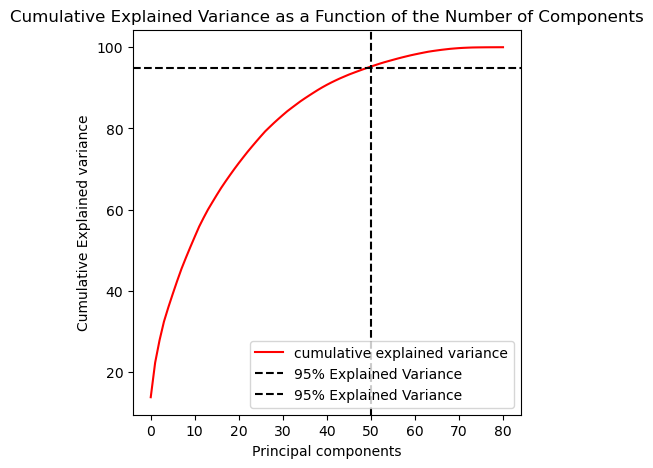

In [359]:
pca = PCA()
# Fits PCA to the scaled training data (X_train_scaled) and transforms it, storing the result in X_train_pca.
X_train_pca = pca.fit_transform(X_train_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(5,5))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.axvline(x = 50, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')

In [360]:
# Logistic Regression with PCA
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

log_reg.fit(X_train_pca, y_train)
y_pred_pca = log_reg.predict(X_test_pca)

In [361]:
y_train_pred = log_reg.predict(X_train_pca)
print("============================================================================================")
print("\nLogistic Regression with PCA (Trained Metrics)")
other_metrics_logistic_model(confusion_matrix(y_train, y_train_pred))


Logistic Regression with PCA (Trained Metrics)


,Value
Evaluation Metrics,
Accuracy,0.8244
Sensitivity/Recall,0.8684
Specificity,0.7804
False Positive Rate,0.2196
Positive Predictive Value/Precision,0.7982
Negative Predictive Value,0.8557
Misclassification Rate,0.1756


In [362]:
print("============================================================================================")
print("\nLogistic Regression with PCA (Test Metrics)")
other_metrics_logistic_model(confusion_matrix(y_test, y_pred_pca))


Logistic Regression with PCA (Test Metrics)


,Value
Evaluation Metrics,
Accuracy,0.7897
Sensitivity/Recall,0.8713
Specificity,0.7805
False Positive Rate,0.2195
Positive Predictive Value/Precision,0.3098
Negative Predictive Value,0.9817
Misclassification Rate,0.2103


In [363]:
# Logistic Regression with PCA and Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 1.25, 5, 10, 100],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

best_log_reg = grid_search.best_estimator_

#best_log_reg = LogisticRegression(C=0.01, random_state=42, solver='saga')
y_pred_pca_tuned = best_log_reg.predict(X_test_pca)


In [364]:
y_train_pred_pca_tuned = best_log_reg.predict(X_train_pca)
print("============================================================================================")
print("\nLogistic Regression with PCA and Hyperparameter Tuning (Train Metrics)")
other_metrics_logistic_model(confusion_matrix(y_train, y_train_pred_pca_tuned))


Logistic Regression with PCA and Hyperparameter Tuning (Train Metrics)


,Value
Evaluation Metrics,
Accuracy,0.8244
Sensitivity/Recall,0.8684
Specificity,0.7804
False Positive Rate,0.2196
Positive Predictive Value/Precision,0.7982
Negative Predictive Value,0.8557
Misclassification Rate,0.1756


In [365]:
print("============================================================================================")
print("\nLogistic Regression with PCA and Hyperparameter Tuning (Test Metrics)")
other_metrics_logistic_model(confusion_matrix(y_test, y_pred_pca_tuned))


Logistic Regression with PCA and Hyperparameter Tuning (Test Metrics)


,Value
Evaluation Metrics,
Accuracy,0.7896
Sensitivity/Recall,0.8706
Specificity,0.7805
False Positive Rate,0.2195
Positive Predictive Value/Precision,0.3096
Negative Predictive Value,0.9816
Misclassification Rate,0.2104


In [366]:
# Random Forest Model with PCA and Hyperparameter Tuning
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(0.95)),
    ('rf', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'rf__max_features': [7],
    'rf__max_depth': [24,25],
    'rf__min_samples_leaf': [100, 200, 300],
    'rf__n_estimators': [20, 50, 75],
    'rf__min_samples_split': [250,350,450],
    'rf__max_leaf_nodes': [25,27]
}

rf_grid_search = RandomizedSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy', n_iter=50)
rf_grid_search.fit(X_train_pca, y_train_res)

In [367]:
# Evaluate Models
rf_best_model = rf_grid_search.best_estimator_

rf_y_pred = rf_best_model.predict(X_test_pca)
rf_y_train_pred = rf_best_model.predict(X_train_pca)
print("============================================================================================")
print("\n Random Forest Model (Train Metrics)")
other_metrics_logistic_model(confusion_matrix(y_train, rf_y_train_pred))

In [368]:
print("============================================================================================")
print("\n Random Forest Model (Test Metrics)")
other_metrics_logistic_model(confusion_matrix(y_test, rf_y_pred))

In [369]:
# XGBoost Model with PCA and Hyperparameter Tuning
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(0.95)),
    ('xgb', XGBClassifier(random_state=42))
])

xgb_param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 6],
    'xgb__learning_rate': [0.01, 0.1]
}

xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='accuracy')
xgb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             param_grid={'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [3, 6],
                         'xgb__n_estimators': [100, 200]},
             scoring='accuracy')

In [370]:
xgb_best_model = xgb_grid_search.best_estimator_

xgb_y_train_pred = xgb_best_model.predict(X_train)
xgb_y_pred = xgb_best_model.predict(X_test)
print("============================================================================================")
print("\nXGBoost Model with PCA and HyperParameter Tuning(Train Metrics)")
other_metrics_logistic_model(confusion_matrix(y_train, xgb_y_train_pred))


XGBoost Model with PCA and HyperParameter Tuning(Train Metrics)


,Value
Evaluation Metrics,
Accuracy,0.9456
Sensitivity/Recall,0.9580
Specificity,0.9332
False Positive Rate,0.0668
Positive Predictive Value/Precision,0.9348
Negative Predictive Value,0.9570
Misclassification Rate,0.0544


In [371]:
print("============================================================================================")
print("\nXGBoost Model with PCA and HyperParameter Tuning(Test Metrics)")
other_metrics_logistic_model(confusion_matrix(y_test, xgb_y_pred))


XGBoost Model with PCA and HyperParameter Tuning(Test Metrics)


,Value
Evaluation Metrics,
Accuracy,0.8896
Sensitivity/Recall,0.7068
Specificity,0.9103
False Positive Rate,0.0897
Positive Predictive Value/Precision,0.4712
Negative Predictive Value,0.9649
Misclassification Rate,0.1104


In [462]:
##Model Predictions

prediction_results = pd.DataFrame({'Model No.':['1','1.1', '1.2', '2','3'],
                                   'Models':['Logistic Regression (RFE)',
                                             'Logistic Regression (PCA)',
                                             'Logistic Regression (PCA+Hyperparameter Tuning)',
                                             'Random Forest (PCA+Hyperparameter Tuning)',
                                             'XGBoost (PCA+Hyperparameter Tuning)' ],
                                    'Accuracy (Train)': [0.8764, 0.8244, 0.8244, 0.0000, 0.9456],
                                   'Recall (Train)':[0.8852, 0.8684, 0.8684, 0.0000, 0.9580],
                                    'Accuracy (Test)':[0.8432, 0.7897, 0.7896, 0.0000, 0.8896],        
                                   'Recall (Test)':[0.6505, 0.8713, 0.8706, 0.0000, 0.7068]})
prediction_results.set_index('Model No.', inplace= True)
print('Model Predictions')
prediction_results

Model Predictions


,Models,Accuracy (Train),Recall (Train),Accuracy (Test),Recall (Test)
Model No.,,,,,
1,Logistic Regression (RFE),0.8764,0.8852,0.8432,0.6505
1.1,Logistic Regression (PCA),0.8244,0.8684,0.7897,0.8713
1.2,Logistic Regression (PCA+Hyperparameter Tuning),0.8244,0.8684,0.7896,0.8706
2,Random Forest (PCA+Hyperparameter Tuning),0.0000,0.0000,0.0000,0.0000
3,XGBoost (PCA+Hyperparameter Tuning),0.9456,0.9580,0.8896,0.7068


# 5. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [465]:
final_cols = X_train.columns

for cols in final_cols:
    if cols not in unseen.columns:
        print(cols)

unseen = unseen[final_cols]

unseen_copy = unseen.copy()

In [467]:
# Create a preprocessor pipeline for scaling and PCA transformation
preprocessor = Pipeline([
    ('scaler', xgb_grid_search.best_estimator_.named_steps['scaler']),
    ('pca', xgb_grid_search.best_estimator_.named_steps['pca'])
])

# Transform the unseen data
unseen_transformed = preprocessor.transform(unseen_copy)

# Access the best XGB model for prediction
xgb_model = xgb_grid_search.best_estimator_.named_steps['xgb']
final_prediction = xgb_model.predict(unseen_transformed)

# Add predictions to the unseen dataset
unseen_copy["churn_probability"] = final_prediction


In [469]:
unseen_copy.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,arpu_avg_67,onnet_mou_avg_67,offnet_mou_avg_67,roam_ic_mou_avg_67,roam_og_mou_avg_67,loc_og_t2t_mou_avg_67,loc_og_t2m_mou_avg_67,loc_og_t2f_mou_avg_67,loc_og_t2c_mou_avg_67,std_og_t2t_mou_avg_67,std_og_t2m_mou_avg_67,std_og_t2f_mou_avg_67,isd_og_mou_avg_67,spl_og_mou_avg_67,og_others_avg_67,loc_ic_t2t_mou_avg_67,loc_ic_t2m_mou_avg_67,loc_ic_t2f_mou_avg_67,std_ic_t2t_mou_avg_67,std_ic_t2m_mou_avg_67,std_ic_t2f_mou_avg_67,spl_ic_mou_avg_67,isd_ic_mou_avg_67,ic_others_avg_67,total_rech_num_avg_67,total_rech_amt_avg_67,max_rech_amt_avg_67,last_day_rch_amt_avg_67,total_rech_data_avg_67,max_rech_data_avg_67,av_rech_amt_data_avg_67,vol_2g_mb_avg_67,vol_3g_mb_avg_67,monthly_2g_avg_67,sachet_2g_avg_67,monthly_3g_avg_67,sachet_3g_avg_67,tenure_1_2_year,tenure_2_3_year,tenure_3_5_year,tenure_5_12_year,churn_probability
0,-0.495097,-0.271883,-0.361413,-0.197357,-0.227306,-0.051386,-0.386926,-0.242359,-0.221683,-0.263599,-0.170953,-0.127023,-0.070377,-0.289062,-0.041894,-0.060510,-0.424470,-0.257355,-0.203535,-0.168494,-0.145935,3.724382,-0.132302,-0.114764,-0.261521,-0.514664,-0.447249,-0.510544,-0.306216,-0.343052,-0.328977,-0.200236,-0.216941,-0.204622,-0.221046,-0.182767,-0.12316,-0.217862,-0.228624,-0.235574,-0.716131,-0.380309,-0.462858,-0.218822,-0.269601,-0.098574,-0.436714,0.493864,-0.313148,-0.358013,-0.292660,-0.162177,-0.10193,-0.401942,-0.322823,-0.013664,-0.545523,-0.290320,-0.271897,-0.298743,-0.169835,4.328986,-0.161424,-0.149346,-0.412565,-0.671764,-0.583135,-0.352878,-0.386752,-0.434771,-0.41534,-0.269446,-0.257519,-0.279234,-0.291372,-0.242883,-0.171383,0,0,1,0,0
1,0.578419,-0.285091,1.021031,-0.197357,-0.227306,-0.064331,2.769745,-0.242359,-0.228930,-0.273162,-0.213153,-0.127023,0.076856,-0.291790,-0.041894,-0.273287,0.962771,-0.257355,-0.203535,-0.255280,-0.145935,-0.230852,2.319923,-0.114764,-0.101035,0.825984,1.575386,-0.510544,-0.306216,-0.343052,-0.328977,-0.200236,-0.216941,-0.204622,-0.221046,-0.182767,-0.12316,-0.217862,-0.228624,-0.235574,0.739233,-0.263811,1.244589,-0.218822,-0.269601,0.253247,3.836461,-0.250690,-0.313148,-0.371965,-0.344880,-0.162177,-0.10193,-0.401942,-0.322823,-0.114791,0.488508,-0.268002,-0.271897,-0.200460,-0.169835,-0.431767,3.617883,-0.149346,-0.494591,0.606600,1.648234,1.038419,-0.386752,-0.434771,-0.41534,-0.269446,-0.257519,-0.279234,-0.291372,-0.242883,-0.171383,0,0,0,1,1
2,1.974066,-0.331301,-0.322217,0.421550,0.746349,-0.274850,-0.458462,-0.242359,-0.228930,-0.273162,-0.298421,-0.127023,-0.070377,-0.291790,-0.041894,-0.301958,-0.499894,-0.257355,-0.203535,-0.255280,-0.145935,-0.230852,-0.132302,-0.114764,-0.101035,2.349448,3.873835,-0.510544,-0.306216,-0.343052,-0.328977,-0.200236,-0.216941,-0.204622,-0.221046,-0.182767,-0.12316,2.442784,3.326504,0.908664,0.428373,-0.446218,-0.513085,1.188041,0.420295,-0.320201,-0.555647,-0.292988,-0.313148,-0.371965,-0.392693,-0.162177,-0.10193,-0.401942,-0.322823,-0.341373,-0.602694,-0.295038,-0.271897,-0.311128,-0.169835,-0.431767,-0.161424,-0.149346,-0.002436,1.398648,3.242070,-0.792235,-0.386752,-0.434771,-0.41534,-0.269446,-0.257519,-0.279234,-0.291372,-0.242883,-0.171383,0,0,0,0,0
3,-0.640123,-0.365231,-0.402950,-0.197357,-0.227306,-0.274850,-0.282958,0.023489,-0.228930,-0.273162,-0.298421,-0.127023,-0.070377,-0.187242,-0.041894,-0.048866,3.512244,-0.192858,-0.203535,-0.078709,-0.145935,-0.230852,0.092804,-0.114764,-0.582493,-0.697479,-0.723063,-0.510544,-0.306216,-

In [471]:
output = pd.DataFrame()
output["id"] = id_column_unseen
output["churn_probability"] = unseen_copy["churn_probability"]
output.head()

,id,churn_probability
0,69999,0
1,70000,1
2,70001,0
3,70002,0
4,70003,0


In [473]:
output.to_csv('Submission.csv',index=False)